# Which phone features most significantly influence its price?

Group 35 (Alex Han, Ihor Parkhomenko, Jingyi Ying, Hank Zhao)

## 1. Introduction

Scholars argue that smartphones evolved from luxurious items into necessities (Tanveer et al.). We use them for "calling and sending messages," "capturing pictures," "socializing," etc. They turned from communication tools into daily "multimedia machines" (Tanveer et al.).

Nevertheless, buying new phones can be challenging and frustrating due to the flood of features they offer (Kobie). To escape this tough choice, consumers often consider only a device's advertised characteristics without inquiring whether the phone price corresponds to them (K. Srujan Raju et al. 773). Hence, they are likely to make an uninformed decision and overpay.

Therefore, it is essential to create an effective **model that would predict a phone's market price given the device's set of characteristics**.

Thus, **we want to create and analyze several linear regression models to decide which variables are most significant for predicting a phone's price**. This study can help consumers evaluate whether the phone's proposed price aligns with the competition and is worth paying.

## 2. Methods and Results

### 2.1 Package Installation

In [1]:
# Installing missing packages
# https://stackoverflow.com/a/4090208/18184038
package_list <- c("psych", "GGally", "car", "leaps", "mltools", "glmnet", "gridExtra")
to_install <- package_list[!(package_list %in% installed.packages()[, "Package"])]
if (length(to_install)) install.packages(to_install)

In [2]:
# Loading libraries
library(tidyverse)
library(ggplot2)
library(dplyr)
library(scales)
library(psych)
library(GGally)
library(broom)
library(car)
library(leaps)
library(mltools)
library(glmnet)
library(grid)
library(gridExtra)

# Setting Seed
set.seed(7)

# Setting Font Size for Plots
font_size <- 22

# Defining Options
options(jupyter.plot_mimetypes = "image/png")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:psych’:

    logit


The following object is masked from ‘package:d

### 2.2 Data Cleaning

We use a dataset containing phones specifications and prices, which scholars scraped from [gadgets360.com](https://www.gadgets360.com/mobiles/best-phones) - an Indian tech news website - and [published](https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices) in **2022** (Garai). Data has **1321** reliable and recent observations.

We will clean and adjust the variables to ease the investigation
- Rename them from the original data set
- Derive `resolution` from another two variables
- Convert `price` from Indian Rupee to US Dollar
- Change categorical variables to factors

In [3]:
variable_descriptions_table <- tibble(
    "Variable Name" = c(
        "price",
        "battery",
        "screen_size",
        "resolution",
        "processor",
        "ram",
        "storage",
        "rear_camera",
        "front_camera",
        "num_of_sims",
        "name",
        "brand",
        "model",
        "touchscreen",
        "os",
        "bluetooth",
        "wifi",
        "gps",
        "three_g",
        "lte"
    ),
    "Description" = c(
        "Phone price in USD",
        "Battery capacity in mAh",
        "Screen Size in Inches across opposite corners",
        "The resolution of the phone: (width $\times$ height) / 1000",
        "Number of processor cores",
        "RAM available in phone in GB",
        "Internal Storage of phone in GB",
        "Resolution of rear camera in MP (0 if unavailable)",
        "Resolution of front camera in MP (0 if unavailable)",
        "Number of SIM card slots in phone",
        "Full name of the phone",
        "Brand of the phone",
        "Model of the phone",
        "Touchscreen enabled or not",
        "Operating system of the phone",
        "Bluetooth enabled or not",
        "Has wifi card or not",
        "Has GPS capability or not",
        "supports 3G or not",
        "supports 4G/LTE or not"
    ),
    "Type" = c(
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Quantitative",
        "Categorical",
        "Categorical",
        "Categorical",
        "Categorical",
        "Categorical",
        "Categorical",
        "Categorical",
        "Categorical",
        "Categorical",
        "Categorical"
    )
)

In [4]:
variable_descriptions_table

Variable Name,Description,Type
<chr>,<chr>,<chr>
price,Phone price in USD,Quantitative
battery,Battery capacity in mAh,Quantitative
screen_size,Screen Size in Inches across opposite corners,Quantitative
resolution,The resolution of the phone: (width $ imes$ height) / 1000,Quantitative
processor,Number of processor cores,Quantitative
ram,RAM available in phone in GB,Quantitative
storage,Internal Storage of phone in GB,Quantitative
rear_camera,Resolution of rear camera in MP (0 if unavailable),Quantitative
front_camera,Resolution of front camera in MP (0 if unavailable),Quantitative


Table 1.0 - Variable Descriptions from Dataset

#### 2.2.1 Reading the Data

In [5]:
url <- "https://raw.githubusercontent.com/Ihor16/stat-301-project/main/data/specs.csv"
data_raw <- read.csv(url)
head(data_raw)

,X,Name,Brand,Model,Battery.capacity..mAh.,Screen.size..inches.,Touchscreen,Resolution.x,Resolution.y,Processor,⋯,Rear.camera,Front.camera,Operating.system,Wi.Fi,Bluetooth,GPS,Number.of.SIMs,X3G,X4G..LTE,Price
,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
1,0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,⋯,48,16,Android,Yes,Yes,Yes,2,Yes,Yes,58998
2,1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,⋯,64,16,Android,Yes,Yes,Yes,2,Yes,Yes,27999
3,2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,⋯,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes,106900
4,3,iPhone 11,Apple,iPhone 11,3110,6.10,Yes,828,1792,6,⋯,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes,62900
5,4,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,Yes,1080,2340,8,⋯,12,32,Android,Yes,Yes,Yes,1,No,No,49990
6,5,OnePlus 7T,OnePlus,7T,3800,6.55,Yes,1080,2400,8,⋯,48,16,Android,Yes,Yes,No,2,Yes,Yes,34930


Table 2.0 - Raw Phone Data

#### 2.2.2 Cleaning the Data

In [6]:
# Conversion rate from INR to USD
# https://www.forbes.com/advisor/money-transfer/currency-converter/inr-usd/
rate <- 0.012282

In [7]:
# Following transformations are made:
# 1. remove column X
# 2. rename variables
# 3. change categorical variables to factors
# 4. compute resolution
# 5. convert price from INR to USD
# 6. convert RAM to GB
phone_data <- data_raw %>%
  select(-X) %>%
  rename(
    name = "Name",
    brand = "Brand",
    model = "Model",
    touchscreen = "Touchscreen",
    os = "Operating.system",
    wifi = "Wi.Fi",
    bluetooth = "Bluetooth",
    gps = "GPS",
    three_g = "X3G",
    lte = "X4G..LTE",
    battery = "Battery.capacity..mAh.",
    screen_size = "Screen.size..inches.",
    resolution_x = "Resolution.x",
    resolution_y = "Resolution.y",
    processor = "Processor",
    ram = "RAM..MB.",
    storage = "Internal.storage..GB.",
    rear_camera = "Rear.camera",
    front_camera = "Front.camera",
    num_of_sims = "Number.of.SIMs",
    price = "Price"
  ) %>%
  mutate(
    price = price * rate,
    resolution = (resolution_x * resolution_y) / 1000,
    ram = ram / 1000,
    name = as.factor(name),
    brand = as.factor(brand),
    model = as.factor(model),
    touchscreen = as.factor(touchscreen),
    os = as.factor(os),
    wifi = as.factor(wifi),
    bluetooth = as.factor(bluetooth),
    gps = as.factor(gps),
    three_g = as.factor(three_g),
    lte = as.factor(lte)
  ) %>%
  relocate(resolution, .before = resolution_x) %>%
  select(-c(resolution_x, resolution_y)) %>%
  drop_na() %>%
  select(price, everything())

In [8]:
head(phone_data)

,price,name,brand,model,battery,screen_size,touchscreen,resolution,processor,ram,storage,rear_camera,front_camera,os,wifi,bluetooth,gps,num_of_sims,three_g,lte
,<dbl>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,724.6134,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,4492.800,8,12,256,48,16,Android,Yes,Yes,Yes,2,Yes,Yes
2,343.8837,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,2592.000,8,6,64,64,16,Android,Yes,Yes,Yes,2,Yes,Yes
3,1312.9458,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,3338.496,6,4,64,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes
4,772.5378,iPhone 11,Apple,iPhone 11,3110,6.10,Yes,1483.776,6,4,64,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes
5,613.9772,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,Yes,2527.200,8,6,128,12,32,Android,Yes,Yes,Yes,1,No,No
6,429.0103,OnePlus 7T,OnePlus,7T,3800,6.55,Yes,2592.000,8,8,128,48,16,Android,Yes,Yes,No,2,Yes,Yes


Table 3.0 - Cleaned Phone Data

In [9]:
# Isolating quantitative variables
phone_data_quantitative <- phone_data %>%
    select_if(is.numeric)

### 2.3 Exploratory Data Analysis

#### 2.3.1 Summary Statistics Table for Quantitative Predictors

In [10]:
describe(phone_data_quantitative) %>%
    select(min, mean, median, max, sd)

,min,mean,median,max,sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
price,6.067308,140.823270,85.96172,2149.227,170.1977791
battery,1010.000000,2938.489330,3000.00000,6000.000,873.5141331
screen_size,2.400000,5.291310,5.20000,7.300,0.6713566
resolution,76.800000,1348.761263,921.60000,8294.400,954.7353441
processor,1.000000,5.551141,4.00000,10.000,2.1965624
ram,0.064000,2.488778,2.00000,12.000,1.6644404
storage,0.064000,30.654864,16.00000,512.000,36.9502412
rear_camera,0.000000,12.070199,12.20000,108.000,8.9483374
front_camera,0.000000,7.037969,5.00000,48.000,6.2954481


Table 4.0 - Summary Statistics for Quantitative Predictors

#### 2.3.2 Exploring Phone Price

In [11]:
options(repr.plot.width = 20, repr.plot.height = 8)

phone_price_plt <- phone_data %>%
    ggplot(aes(x = price, fill = brand)) +
    geom_histogram(binwidth = 50) +
    geom_vline(xintercept = mean(phone_data$price), color = "red", alpha = 0.3, linewidth = 2) +
    annotate("text", x = 400, y = 300, label = "Mean Phone Price", color = "red", size = 6) +
    scale_x_continuous(breaks = pretty_breaks()) +
    labs(x = "Price (in USD)", y = "Count") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Figure 1.0 - Distribution of Phone Prices (in USD)")

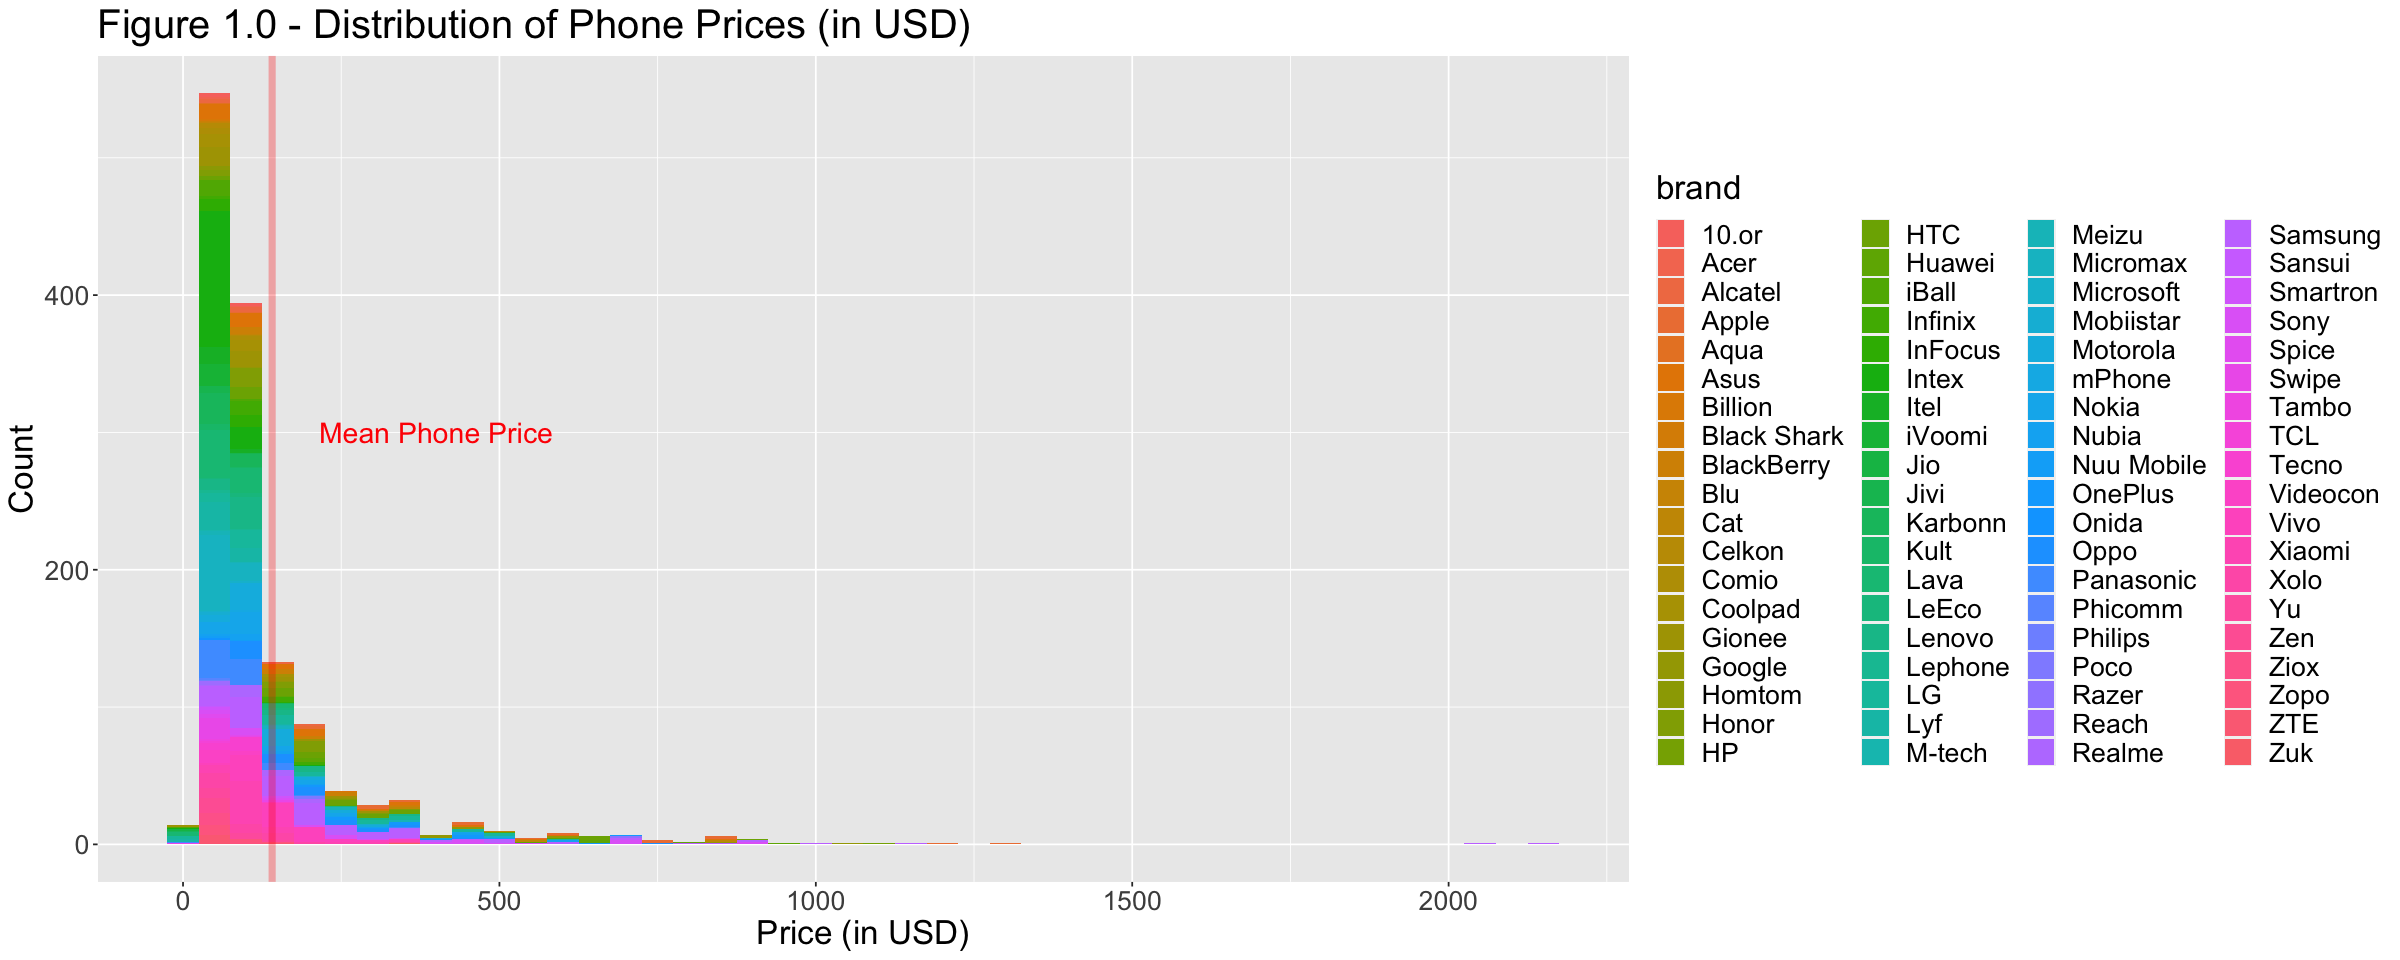

In [12]:
phone_price_plt

The histogram of phone prices is right skewed with mean price of US$140.82. 

#### 2.3.3 Exploring Phone Price Across Brands

In [13]:
# Get Average Price by Brand
phone_data_avg_price_brand <- phone_data %>%
    group_by(brand) %>%
    summarize(avg_price = mean(price))

In [14]:
# Get Top 20 Brands by Average Price
top_20_brands_data <- phone_data_avg_price_brand %>%
    arrange(desc(avg_price)) %>%
    head(20)

top_20_brands <- top_20_brands_data %>%
    select(brand) %>%
    unlist()

# Get Bottom 20 Brands by Average Price
bot_20_brands_data <- phone_data_avg_price_brand %>%
    arrange(avg_price) %>%
    head(20)

bot_20_brands <-bot_20_brands_data %>%
    select(brand) %>%
    unlist()

In [15]:
top_20_brands_data

brand,avg_price
<fct>,<dbl>
HP,1089.6468
Razer,675.3872
Apple,558.9596
Cat,555.3890
Huawei,473.6523
Google,468.7597
OnePlus,404.1853
Black Shark,368.4477
Zuk,357.7010


Table 5.0 - Top 20 Phone Brands based on Average Price (USD)

In [16]:
bot_20_brands_data

brand,avg_price
<fct>,<dbl>
Jio,15.34022
Reach,31.06937
Philips,39.29012
Phicomm,39.76912
Tambo,44.15379
Ziox,45.02172
Zen,45.22009
Jivi,46.86606
Sansui,47.89980


Table 6.0 - Bottom 20 Phone Brands based on Average Price (USD)

In [17]:
# Top 20 Brands by Average Price
top_20_brands_phone_data <- phone_data %>%
    filter(brand %in% top_20_brands) %>%
    group_by(brand) %>%
    summarize(price = price)

# Bottom 20 Brands by Average Price
bot_20_brands_phone_data <- phone_data %>%
    filter(brand %in% bot_20_brands) %>%
    group_by(brand) %>%
    summarize(price = price)

`summarise()` has grouped output by 'brand'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'brand'. You can override using the
`.groups` argument.


In [18]:
# Top 20 Brands Plot
top_20_brands_phone_plt <- top_20_brands_phone_data %>%
    ggplot(aes(x = brand, y = price, fill = brand)) +
    geom_boxplot() +
    labs(x = "Brand", y = "Price (in USD)") +
    theme(text = element_text(size = 24)) +
    ggtitle("Figure 2.0 - Phone Prices Across Top 20 Brands (in USD)")

# Bottom 20 Brands Plot
bot_20_brands_phone_plt <- bot_20_brands_phone_data %>%
    ggplot(aes(x = brand, y = price, fill = brand)) +
    geom_boxplot() +
    labs(x = "Brand", y = "Price (in USD)") +
    theme(text = element_text(size = 24)) +
    ggtitle("Figure 3.0 - Phone Prices Across Bottom 20 Brands (in USD)")

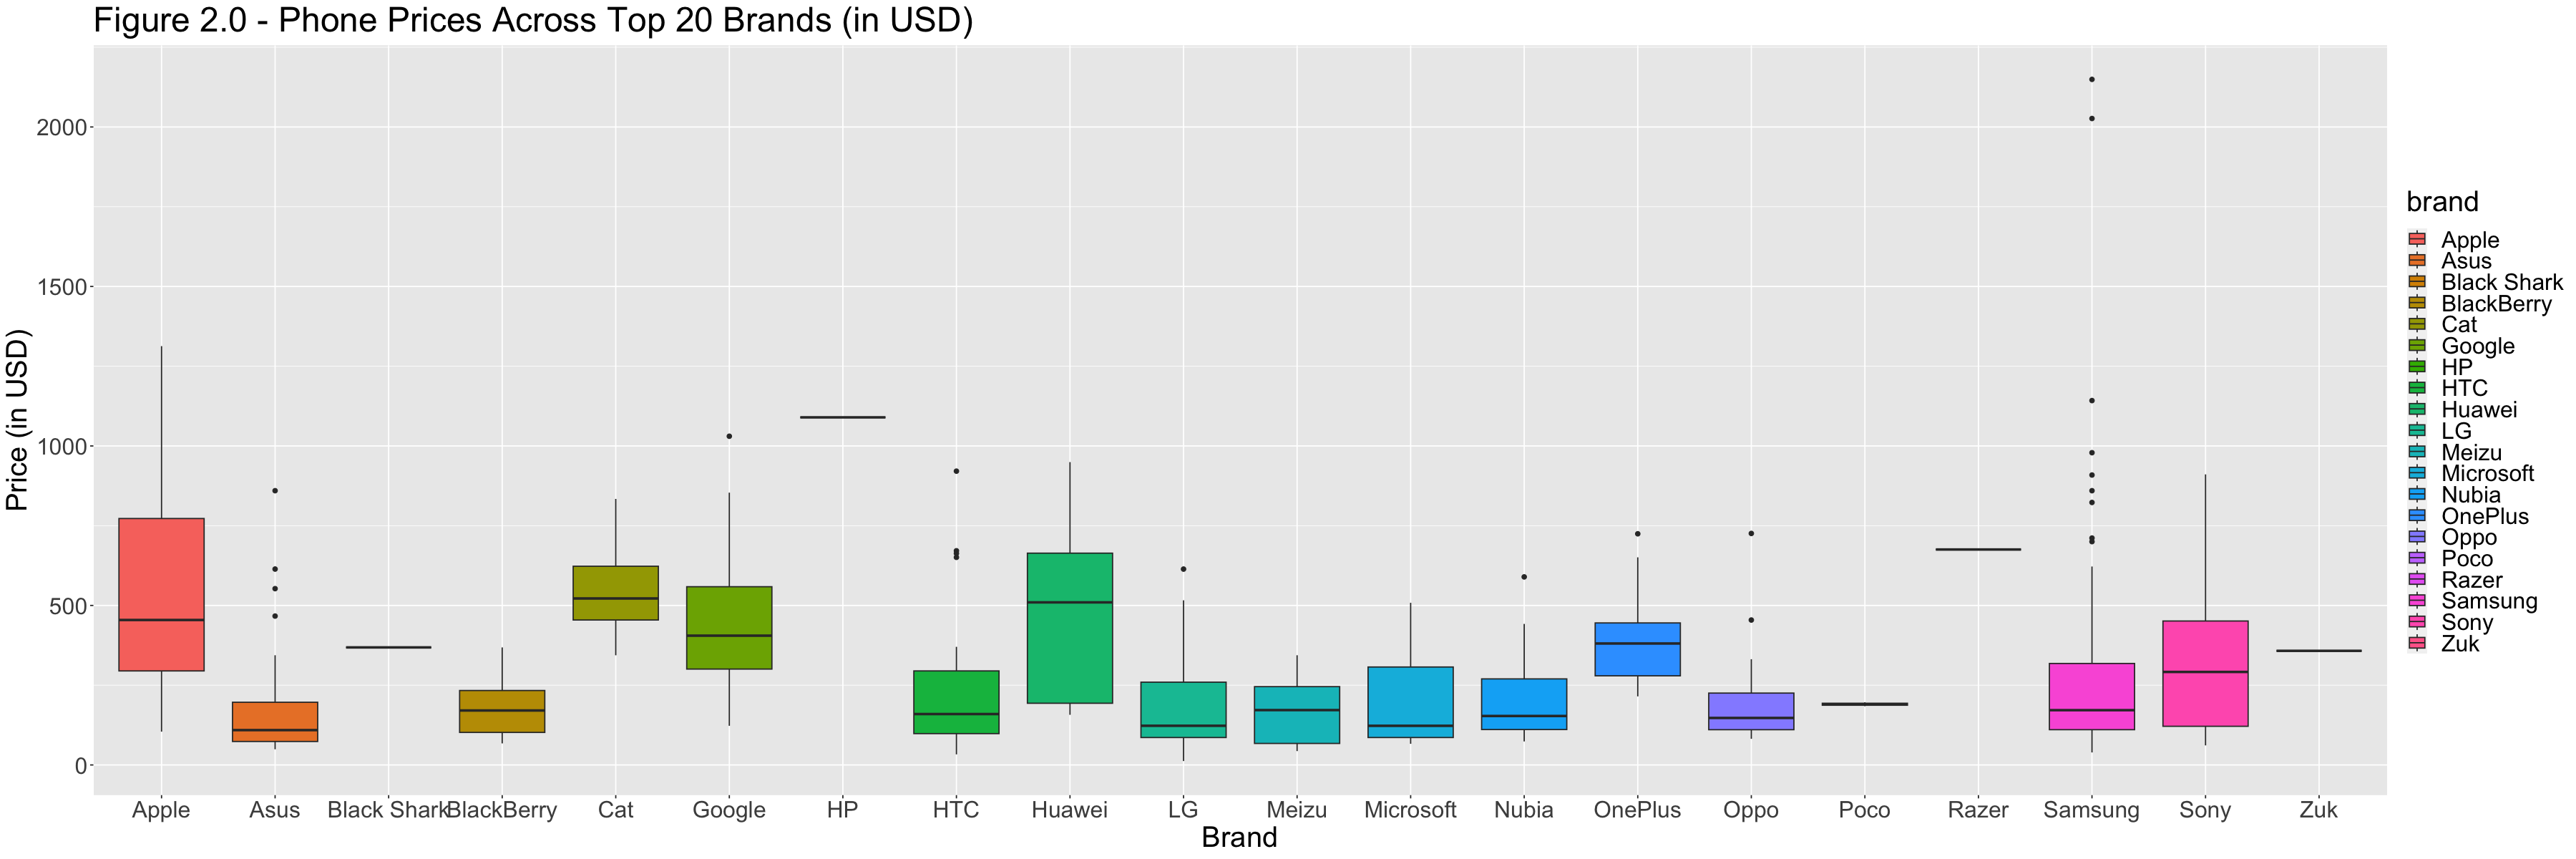

In [19]:
options(repr.plot.width = 30, repr.plot.height = 10)

top_20_brands_phone_plt

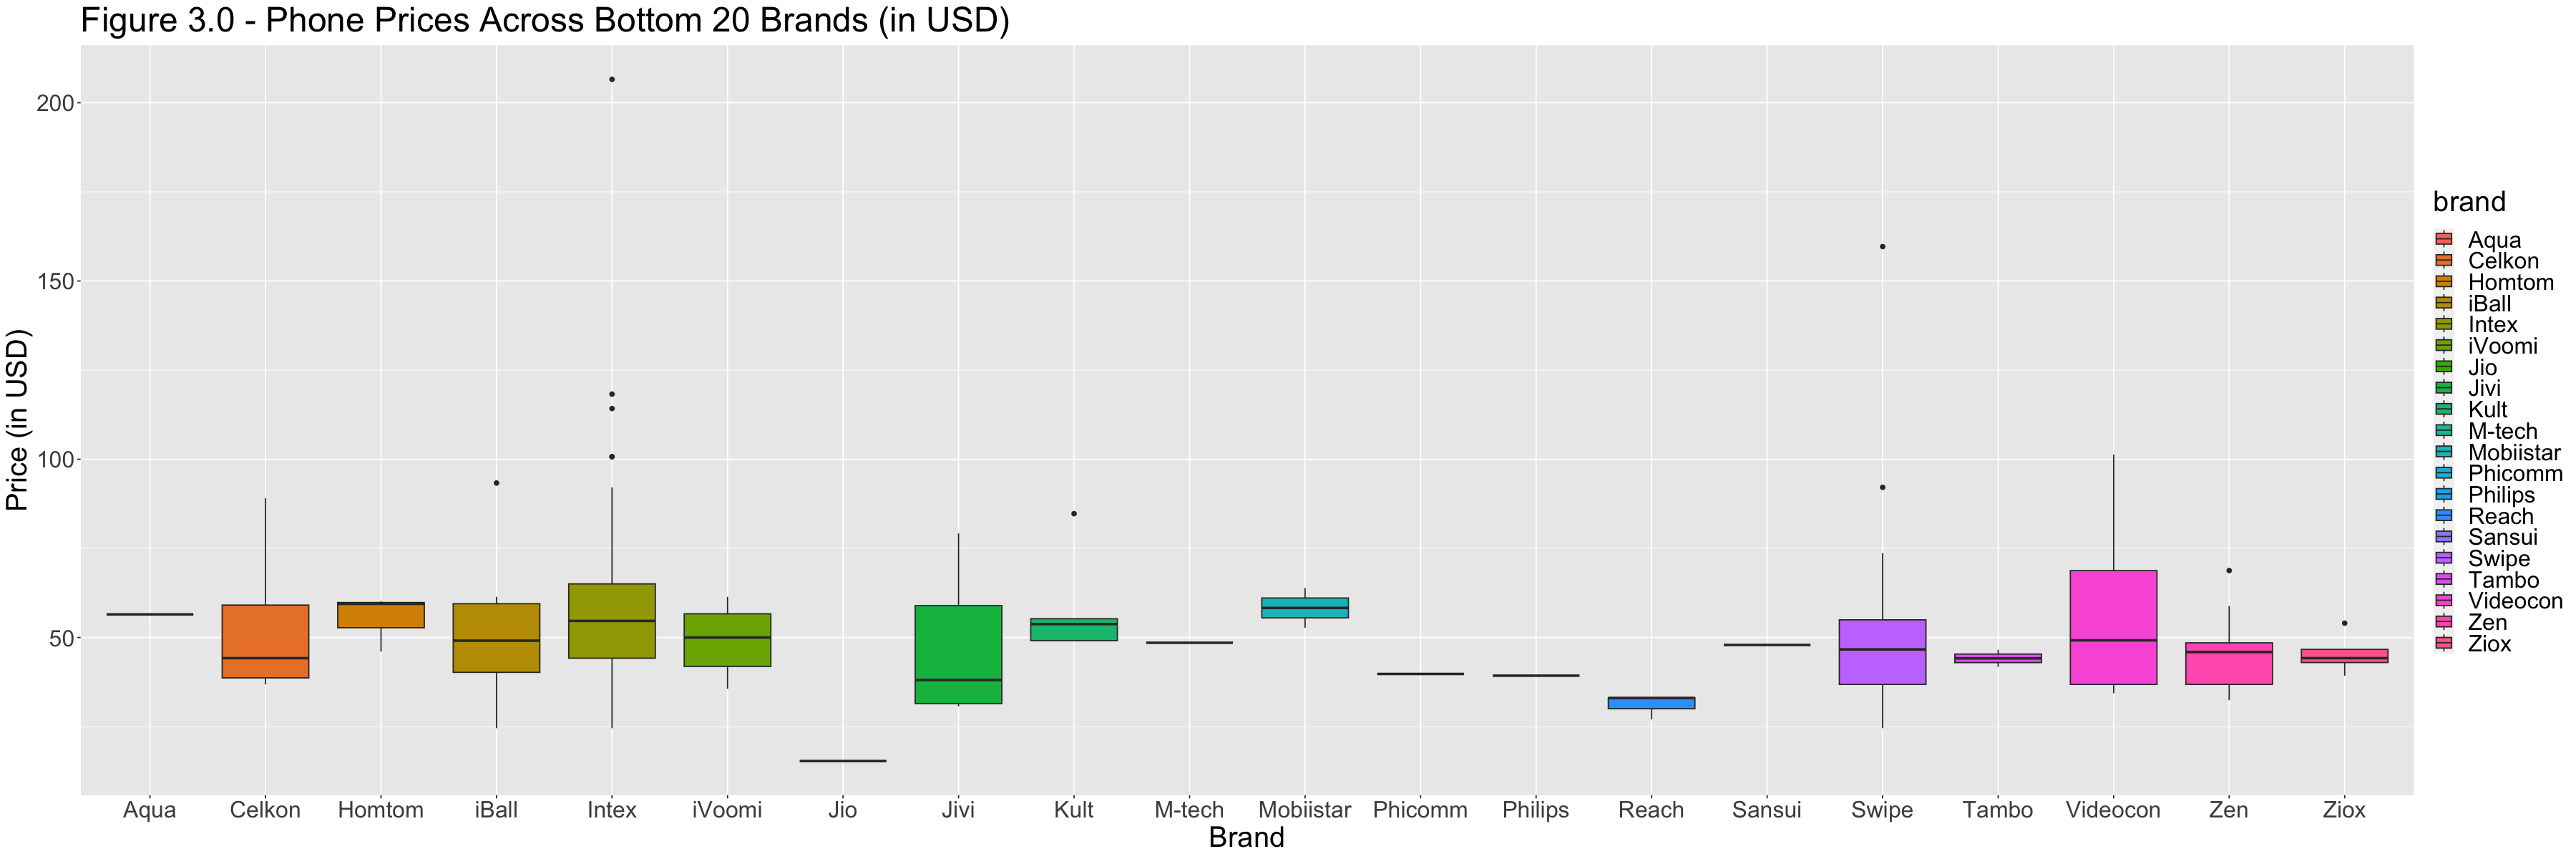

In [20]:
options(repr.plot.width = 30, repr.plot.height = 10)

bot_20_brands_phone_plt

Above is for just average price across all models, perhaps we see a different ordering for flagship models.

In [21]:
# Get the most expensive models (i.e. flagship) for each brand
phone_data_avg_price_brand_flagship <- phone_data %>%
    group_by(brand, model) %>%
    summarize(avg_price = mean(price)) %>%
    group_by(brand) %>%
    filter(avg_price == max(avg_price))   

`summarise()` has grouped output by 'brand'. You can override using the
`.groups` argument.


In [22]:
# Get Top 20 Brands by Average Price of Flagship Model
top_20_brands_flagship_data <- phone_data_avg_price_brand_flagship %>%
    arrange(desc(avg_price)) %>%
    head(20)

# Get Bottom 20 Brands by Average Price of Flagship Model
bot_20_brands_flagship_data <- phone_data_avg_price_brand_flagship %>%
    arrange(avg_price) %>%
    head(20)

In [23]:
top_20_brands_flagship_data

brand,model,avg_price
<fct>,<fct>,<dbl>
Samsung,Galaxy Z Flip,2149.2272
Apple,iPhone 11 Pro Max,1312.9458
HP,Elite x3,1089.6468
Google,Pixel 4 XL,1030.4598
Huawei,Mate 30 Pro,949.3863
HTC,U12+,921.0272
Sony,Xperia XA2 Ultra,910.8822
Asus,ROG Phone,859.7277
Cat,S61,833.9478


Table 7.0 - Top 20 Phone Brands based on Average Price of Flagship Model (USD)

In [24]:
bot_20_brands_flagship_data

brand,model,avg_price
<fct>,<fct>,<dbl>
Jio,Phone,15.34022
Reach,Allure,33.14912
Philips,Xenium S309,39.29012
Phicomm,Passion 660,39.76912
Tambo,TA-3,46.54878
Sansui,Horizon 1,47.89980
M-tech,TEZ4G,48.51390
Ziox,Astra Colors 4G,54.02852
Aqua,Jazz,56.48492


Table 8.0 - Top 20 Phone Brands based on Average Price of Flagship Model (USD)

In [25]:
# Top 20 Brands Plot
top_20_brands_phone_flagship_plt <- top_20_brands_flagship_data %>%
    ggplot(aes(x = brand, y = avg_price, fill = brand)) +
    geom_bar(stat = "identity") +
    labs(x = "Brand", y = "Price (in USD)") +
    theme(text = element_text(size = 25)) +
    ggtitle("Figure 4.0 - Phone Prices Across Top 20 Brands for Flagship Models (in USD)")

# Bottom 20 Brands Plot
bot_20_brands_phone_flagship_plt <- bot_20_brands_flagship_data %>%
    ggplot(aes(x = brand, y = avg_price, fill = brand)) +
    geom_bar(stat = "identity") +
    labs(x = "Brand", y = "Price (in USD)") +
    theme(text = element_text(size = 25)) +
    ggtitle("Figure 5.0 - Phone Prices Across Bottom 20 Brands for Flagship Models (in USD)")

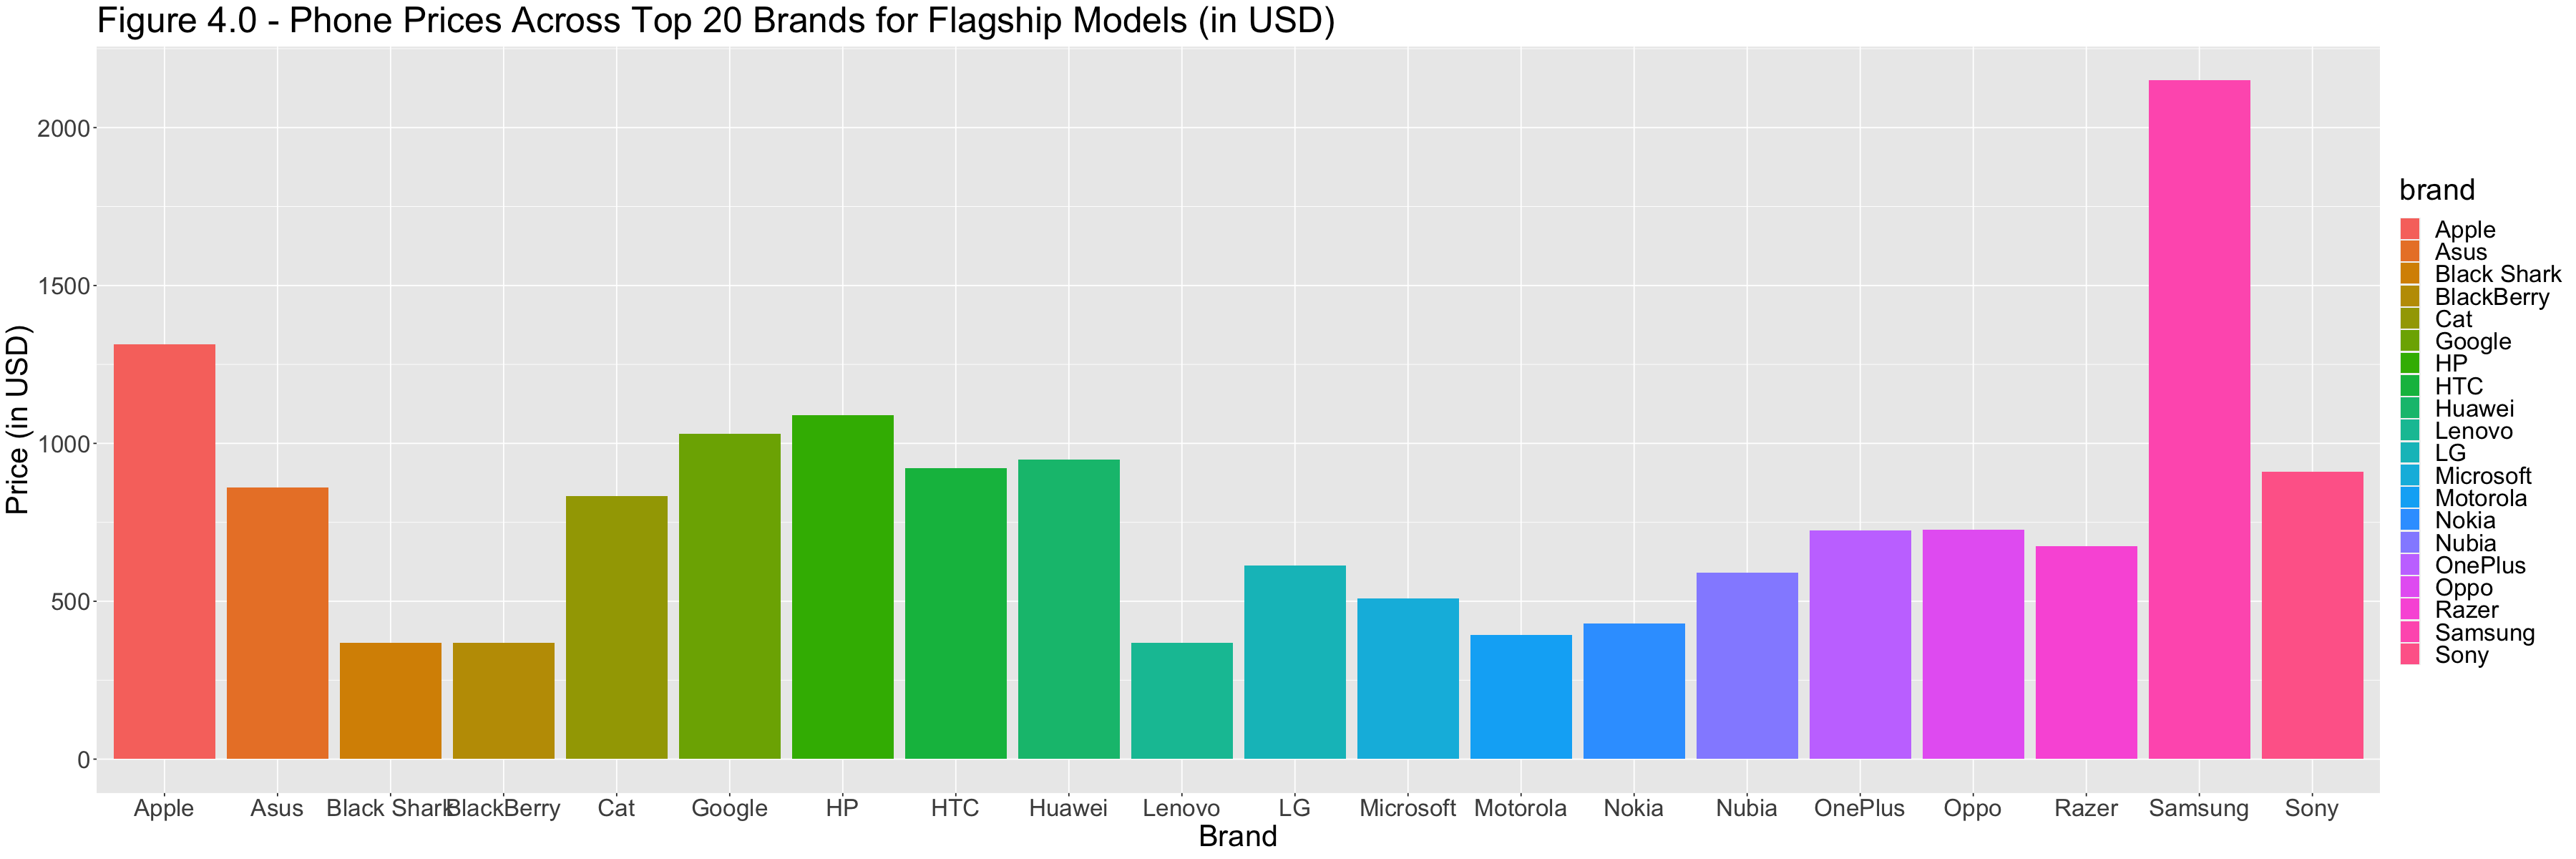

In [26]:
options(repr.plot.width = 30, repr.plot.height = 10)

top_20_brands_phone_flagship_plt

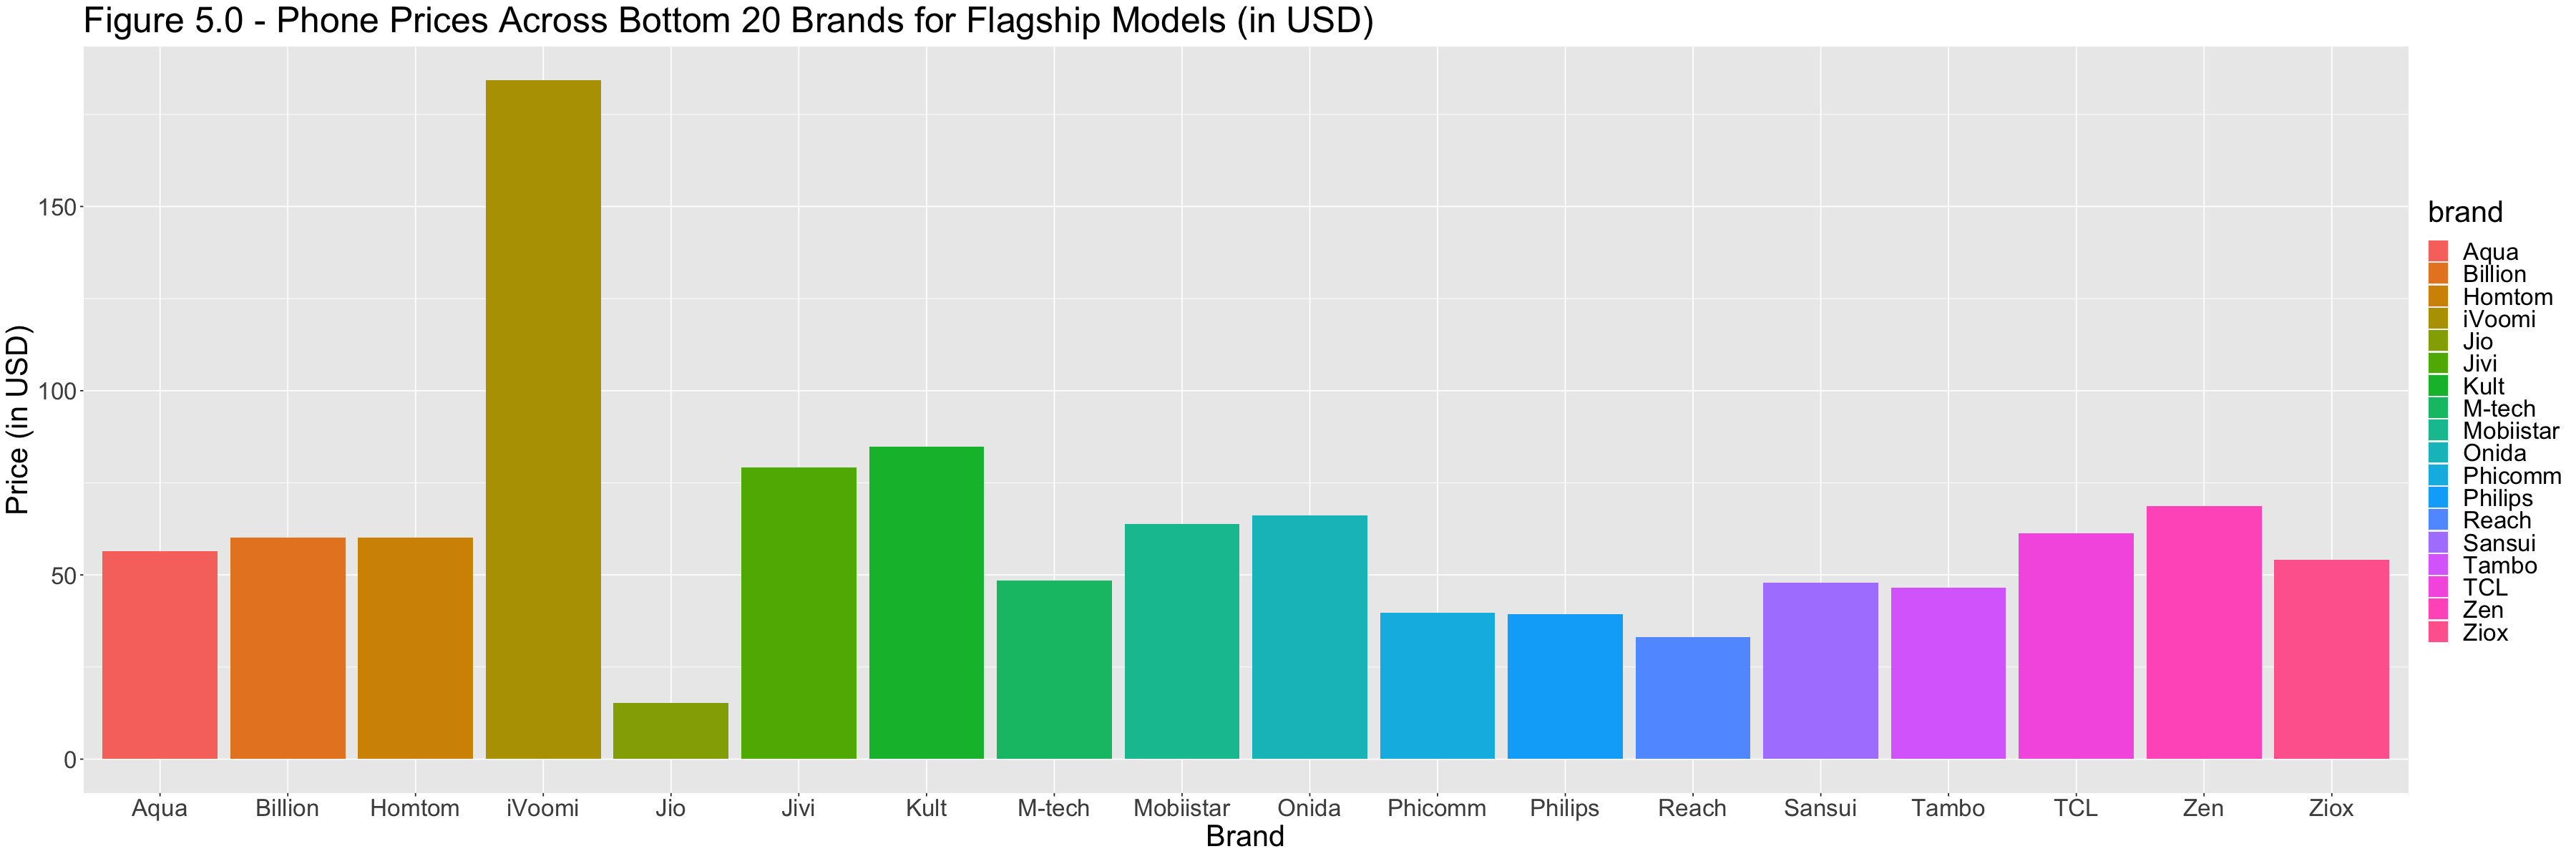

In [27]:
options(repr.plot.width = 30, repr.plot.height = 10)

bot_20_brands_phone_flagship_plt

#### 2.3.4 Analyzing Correlation Matrix

We check for potential multicolinearity and covariates with high correlation with our response using a **correlation heat map** visualizing "the strength of relationships between numerical variables" (Kumar).

In [28]:
# Creating a correlation matrix for all quantitative variables
phone_data_corr_matrix <- phone_data_quantitative %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

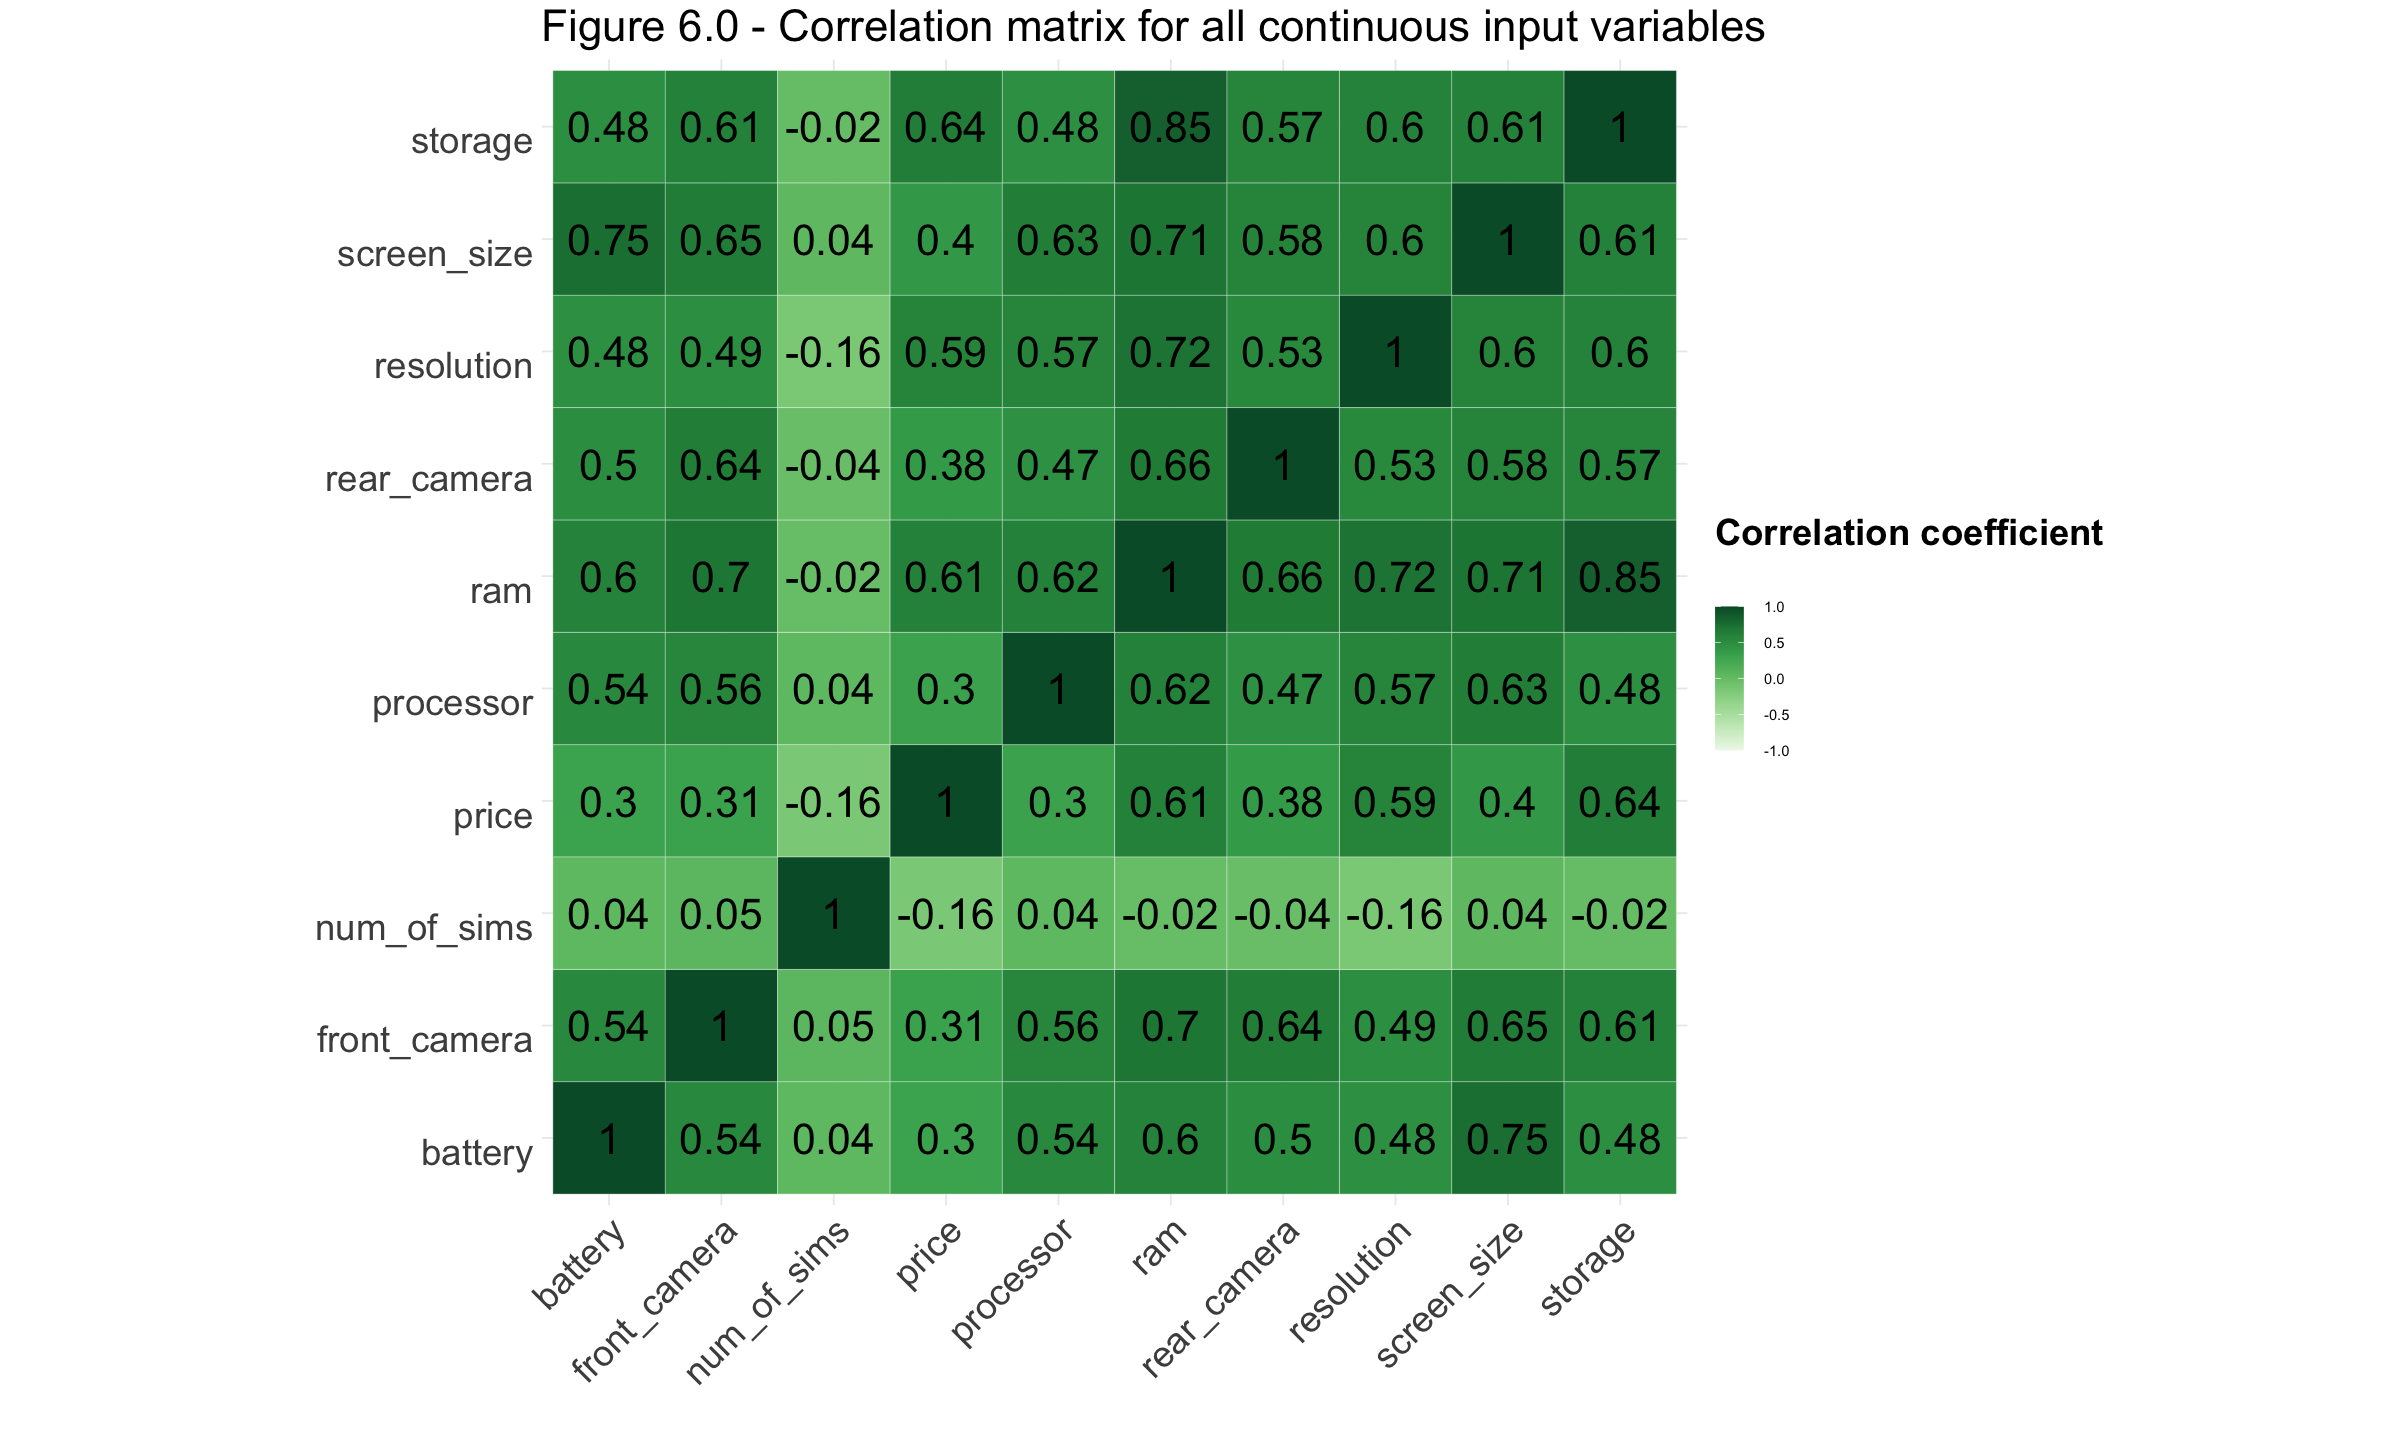

In [29]:
options(repr.plot.width = 20, repr.plot.height = 12)

# Creating the heat map plot
phone_data_corr_matrix %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller(
    "Correlation coefficient \n",
    palette = "Greens",
    direction = 1,
    limits = c(-1, 1)
  ) +
  theme_minimal() +
  labs(
    title = "Figure 6.0 - Correlation matrix for all continuous input variables",
    x = "", y = "") +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = font_size, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = font_size, hjust = 1
    ),
    legend.title = element_text(size = font_size, face = "bold"),
    title = element_text(size = font_size)
  ) +
  coord_fixed() +
  geom_text(aes(x = var1,
                y = var2,
                label = round(corr, 2)),
            color = "black",
            size = 9
  )

We observe these variable pairs with correlation $\geq$ 0.7:

In [30]:
variable_pair_table <- tibble(
    "Variable Pair" = c(
        "storage and ram",
        "screen_size and battery",
        "resolution and ram",
        "screen_size and ram",
        "ram and front_camera"
    ),
    "Correlation Value" = c(0.85, 0.75, 0.72, 0.71, 0.7)
)

In [31]:
variable_pair_table

Variable Pair,Correlation Value
<chr>,<dbl>
storage and ram,0.85
screen_size and battery,0.75
resolution and ram,0.72
screen_size and ram,0.71
ram and front_camera,0.70


Table 7.0 - Variable Pairs of Highly Correlated Covariates

We now assess the multicollinearity rigorously and find whether the correlations presented above are problematic by creating a function that calculates **VIF**, a measure of "how much the variance of an independent variable is influenced by its correlation with the other independent variables" (Potters).

#### 2.3.5 Analyzing Variance Inflation Factor (VIF)

In [32]:
# Function for Calculating VIF
calculate_vif <- function(data_set) {
  # Creating a multiple linear regression for `price` using all input variables from the given data set
  mlr <- data_set %>%
    lm(formula = price ~ .)

  # Using Variance Inflation Factor (VIF) to quantify the possible multicollinearity
  mlr %>%
    vif() %>%
    as.data.frame() %>%
    rename(VIF = ".") %>%
    round(3) %>%
    arrange(desc(VIF)) %>%
    head(5)
}

In [40]:
# Calculating VIF values using the whole training set
calculate_vif(select_if(phone_data, is.numeric))

,VIF
,<dbl>
ram,6.156
storage,3.658
screen_size,3.405
front_camera,2.446
resolution,2.381


Table 8.0 - VIF from Data

> `ram` and `storage` have the highest VIFs, which we expected because their correlation in the heat map was the highest.

Scholars argue that VIF above 10 denotes multicollinearity, while others say values above 5 are also problematic (Bock).

Therefore, we try to remedy our **6.156** VIF for `ram` by:
- Removing highly correlated variables
- Adjusting the `ram` variable and changing its interpretation

In [42]:
# Calculating VIFs after dropping `storage`
calculate_vif(select_if(phone_data, is.numeric) %>% select(-storage))

,VIF
,<dbl>
ram,3.572
screen_size,3.376
front_camera,2.437
resolution,2.381
battery,2.346


Table 9.0 - VIF from Data without Storage

In [43]:
# Calculating VIFs after dropping `front_camera`
calculate_vif(select_if(phone_data, is.numeric) %>% select(-front_camera))

,VIF
,<dbl>
ram,5.940
storage,3.644
screen_size,3.301
battery,2.366
resolution,2.351


Table 10.0 - VIF From Data without Front Camera

In [44]:
# Adjusting `ram` column to indicate how much a phone's ram capacity is above average
phone_data_adjusted_ram <- select_if(phone_data, is.numeric) %>%
  mutate(ram = ram - 4)

# Calculating VIFs after adjusting `ram`
calculate_vif(phone_data_adjusted_ram)

,VIF
,<dbl>
ram,6.156
storage,3.658
screen_size,3.405
front_camera,2.446
resolution,2.381


Table 11.0 - VIF From Data Post Ram Adjustment

VIFs become significantly smaller after we drop `storage`. However, scholars consider this variable significant for predicting a phone's price (Listianingrum et al.), so we keep it as it may give our models more information.

Thus, we continue our investigation without changing the data.

### 2.4 Training, Validation, Test Set

In [45]:
# Adding `ID` column to the full data set
phone_data$ID <- rownames(phone_data)

# (1) Shuffling the full data set
# (2) Selecting 70% of the observations
# (3) Assigning those to the training data set
phone_training <- phone_data %>%
  sample_n(size = nrow(phone_data) * 0.7)

# Assigning the rest 30% of the observations to the testing set
phone_testing <- anti_join(
  x = phone_data,
  y = phone_training,
  by = "ID"
)

# Dropping the `ID` column from the created data sets
phone_training <- phone_training %>%
  select(-ID)
phone_testing <- phone_testing %>%
  select(-ID)

# Calculating the number of observations in training and testing sets
tibble(
  data_set = c("training_data", "testing_data"),
  num_of_obs = c(phone_training %>% nrow(), phone_testing %>% nrow())
)

data_set,num_of_obs
<chr>,<int>
training_data,951
testing_data,408


### 2.5 Model Fitting

#### 2.5.1 Max MLR Model (Quantitative Variables Only)

First, we will try fitting a model with all the quantitative variables.

In [46]:
# Building predictive Ordinary Least Squares LR model with all input variables
phone_model_full <- lm(
    formula = price ~ battery + screen_size + resolution + processor + ram + storage + rear_camera + front_camera + num_of_sims,
    phone_training
)

# Displaying the summary statistics of the full MLR model
summary(phone_model_full)


Call:
lm(formula = price ~ battery + screen_size + resolution + processor + 
    ram + storage + rear_camera + front_camera + num_of_sims, 
    data = phone_training)

Residuals:
    Min      1Q  Median      3Q     Max 
-501.02  -44.73  -10.81   18.91 1299.58 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  128.617321  44.392826   2.897  0.00385 ** 
battery       -0.008774   0.006717  -1.306  0.19176    
screen_size   -4.390087  10.516729  -0.417  0.67645    
resolution     0.053082   0.006790   7.818 1.43e-14 ***
processor     -6.660624   2.486196  -2.679  0.00751 ** 
ram           25.722707   5.841676   4.403 1.19e-05 ***
storage        2.198330   0.190165  11.560  < 2e-16 ***
rear_camera   -0.385539   0.627263  -0.615  0.53894    
front_camera  -4.778191   0.940744  -5.079 4.57e-07 ***
num_of_sims  -34.579818  10.700464  -3.232  0.00127 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119.1 on 941 d

In [47]:
# Obtaining out-of-sample predictions for `price` from the testing set using the full model
phone_model_full_test <- predict(
  object = phone_model_full,
  newdata = phone_testing,
)

# Calculating the RMSE value for the full model
phone_model_full_rmse <- rmse(
  preds = phone_model_full_test,
  actuals = phone_testing$price
)

phone_model_full_rmse

[1] 114.1929

#### 2.5.2 Single Covariate Model (Quantitative Variable with Highest Correlation with Price)

Next, we will try fitting a model with only the covariate with the highest correlation with price (i.e. `storage`).

In [48]:
# Building predictive Ordinary Least Squares LR model with just the storage covariate
phone_model_single_covariate <- lm(
    formula = price ~ storage,
    phone_training
)

# Displaying the summary statistics of the full MLR model
summary(phone_model_single_covariate)


Call:
lm(formula = price ~ storage, data = phone_training)

Residuals:
    Min      1Q  Median      3Q     Max 
-537.29  -42.74  -23.80    6.96 1328.22 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  49.2413     5.3648   9.179   <2e-16 ***
storage       3.0147     0.1107  27.241   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 129.3 on 949 degrees of freedom
Multiple R-squared:  0.4388,	Adjusted R-squared:  0.4382 
F-statistic: 742.1 on 1 and 949 DF,  p-value: < 2.2e-16


In [49]:
# Obtaining out-of-sample predictions for `price` from the testing set using the full model
phone_model_single_covariate_test <- predict(
  object = phone_model_single_covariate,
  newdata = phone_testing,
)

# Calculating the RMSE value for the full model
phone_model_single_covariate_rmse <- rmse(
  preds = phone_model_single_covariate_test,
  actuals = phone_testing$price
)

phone_model_single_covariate_rmse

[1] 132.5474

#### 2.5.3 Reduced MLR Model Based on Correlation

We take the full MLR model from 2.5.1 and remove the highly correlated covariates (from the correlation matrix analysis in EDA). Specifically, we'll try removing `ram` and `battery` since it's highly correlated with covariates such as storage, scrreen_size, etc. (see Figure 6.0).

In [50]:
# Building predictive Ordinary Least Squares LR model with just the storage covariate
phone_model_full_correlation_reduced <- lm(
    formula = price ~ screen_size + resolution + processor + storage + rear_camera + front_camera + num_of_sims,
    phone_training
)

# Displaying the summary statistics of the full MLR model
summary(phone_model_full_correlation_reduced)


Call:
lm(formula = price ~ screen_size + resolution + processor + storage + 
    rear_camera + front_camera + num_of_sims, data = phone_training)

Residuals:
    Min      1Q  Median      3Q     Max 
-524.23  -43.77  -12.42   17.65 1302.62 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  129.381958  43.131132   3.000  0.00277 ** 
screen_size   -6.790104   9.007379  -0.754  0.45113    
resolution     0.062856   0.006478   9.703  < 2e-16 ***
processor     -5.271237   2.479544  -2.126  0.03377 *  
storage        2.726366   0.149577  18.227  < 2e-16 ***
rear_camera    0.105077   0.618030   0.170  0.86503    
front_camera  -3.917313   0.926270  -4.229 2.57e-05 ***
num_of_sims  -34.094728  10.799788  -3.157  0.00164 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 120.2 on 943 degrees of freedom
Multiple R-squared:  0.5178,	Adjusted R-squared:  0.5142 
F-statistic: 144.6 on 7 and 943 DF,  p-value: < 2.2e-16


In [51]:
# Obtaining out-of-sample predictions for `price` from the testing set using the full model
phone_model_full_correlation_reduced_test <- predict(
  object = phone_model_full_correlation_reduced,
  newdata = phone_testing,
)

# Calculating the RMSE value for the full model
phone_model_full_correlation_reduced_rmse <- rmse(
  preds = phone_model_full_correlation_reduced_test,
  actuals = phone_testing$price
)

phone_model_full_correlation_reduced_rmse

[1] 114.5909

#### 2.5.4 Reduced MLR Model Based on Forward Selection

We algorithmically select the covariates using the forward selection method.

In [52]:
# Performing forward variable selection on the training set
phone_forward_sel <- regsubsets(
  x = price ~ .,
  nvmax = ncol(select_if(phone_training, is.numeric)) - 1,
  data = select_if(phone_training, is.numeric),
  method = "forward"
)

phone_forward_sel_summary <- summary(phone_forward_sel)
phone_forward_sel_summary

Subset selection object
Call: regsubsets.formula(x = price ~ ., nvmax = ncol(select_if(phone_training, 
    is.numeric)) - 1, data = select_if(phone_training, is.numeric), 
    method = "forward")
9 Variables  (and intercept)
             Forced in Forced out
battery          FALSE      FALSE
screen_size      FALSE      FALSE
resolution       FALSE      FALSE
processor        FALSE      FALSE
ram              FALSE      FALSE
storage          FALSE      FALSE
rear_camera      FALSE      FALSE
front_camera     FALSE      FALSE
num_of_sims      FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward
         battery screen_size resolution processor ram storage rear_camera
1  ( 1 ) " "     " "         " "        " "       " " "*"     " "        
2  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
3  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
4  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
5  (

We compare the 9 potential model's Mallows' Cp values, a metric denoting "how much error is left unexplained by the partial model" (Stephanie). We'd ideally want models with the smallest Cp.

In [53]:
# Storing variable selection metrics
phone_forward_sel_summary_df <- tibble(
  n_input_vars = 1:9,
  cp = phone_forward_sel_summary$cp
)
phone_forward_sel_summary_df

# Saving the row with the smallest Cp value
min_cp <- phone_forward_sel_summary_df %>%
    filter(cp == min(phone_forward_sel_summary_df$cp))

n_input_vars,cp
<int>,<dbl>
1,171.392689
2,78.180654
3,37.645136
4,26.702070
5,16.165148
6,8.056393
7,6.576127
8,8.174255
9,10.000000


Table 12.0 - Comparing Number of Covariates with Mallows' Cp Statistic

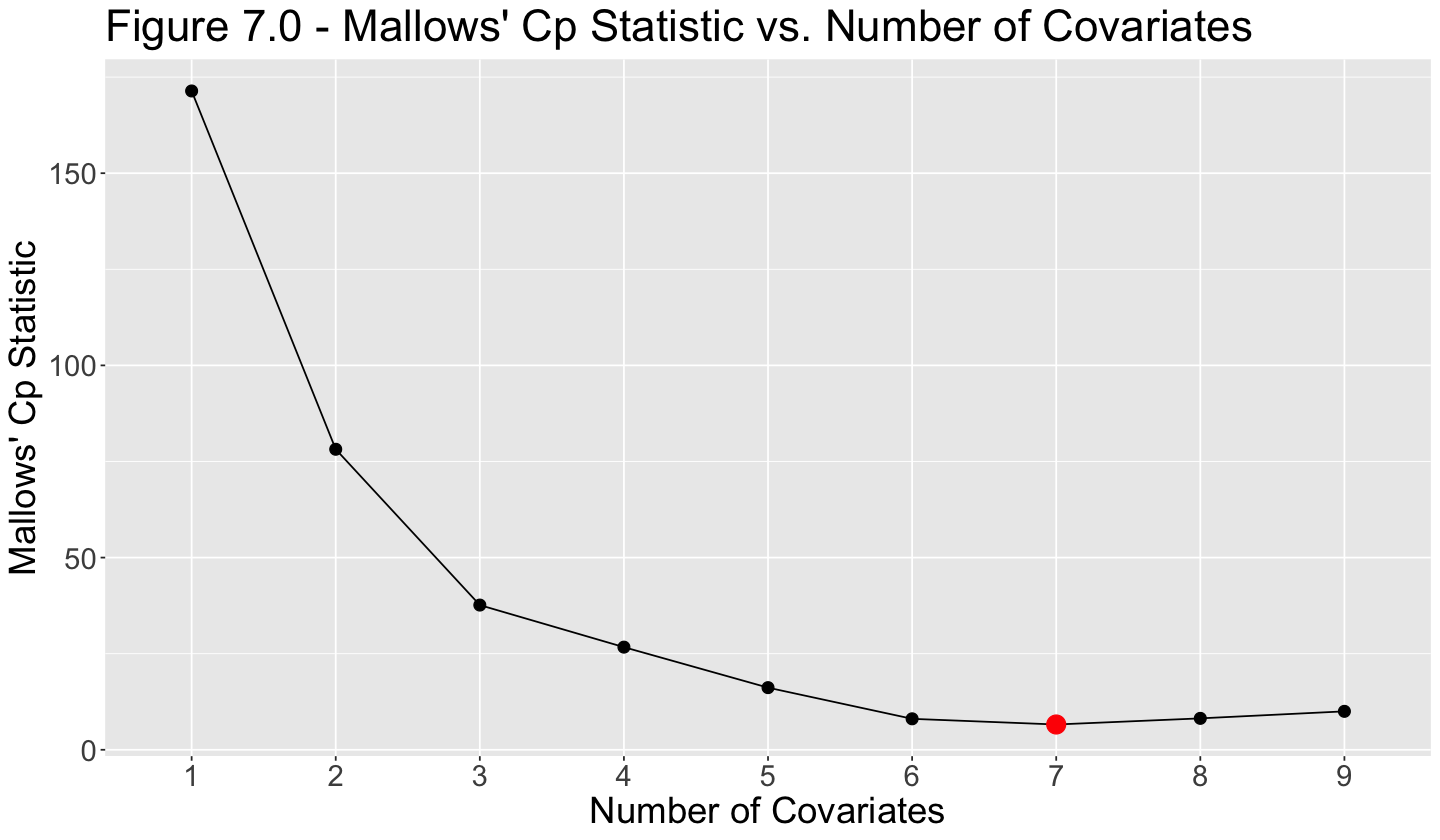

In [54]:
options(repr.plot.width = 12, repr.plot.height = 7)

# Plotting Cp values from the variable selection summary table
phone_forward_sel_summary_df %>%
  ggplot(aes(x = n_input_vars, y = cp)) +
  geom_line() +
  geom_point(aes(x = n_input_vars, y = cp), size = 3) +
  scale_x_discrete(limits = factor(1:9)) +
  geom_point(
    data = min_cp,
    color = "red",
    size = 5
  ) +
  labs(
    title = "Figure 7.0 - Mallows' Cp Statistic vs. Number of Covariates",
    x = "Number of Covariates",
    y = "Mallows' Cp Statistic"
  ) +
  theme(text = element_text(size = font_size))

The model with 7 covariates has the lowest Mallows' Cp statistic but ones with 6 and 8 also have very low cp values. Thus, we will test all three models.

In [55]:
# Building a model using the 7 covariates selected by the stepwise forward selection
phone_model_stepwise_7 <- phone_training %>%
  lm(formula = price ~ battery +
    resolution +
    processor +
    ram +
    storage +
    front_camera +
    num_of_sims
  )

summary(phone_model_stepwise_7)


Call:
lm(formula = price ~ battery + resolution + processor + ram + 
    storage + front_camera + num_of_sims, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-507.84  -47.05  -10.68   18.43 1303.47 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  112.265086  24.075787   4.663 3.57e-06 ***
battery       -0.010642   0.005700  -1.867  0.06222 .  
resolution     0.052218   0.006677   7.821 1.40e-14 ***
processor     -6.809545   2.435650  -2.796  0.00528 ** 
ram           24.875544   5.715278   4.352 1.49e-05 ***
storage        2.187977   0.188990  11.577  < 2e-16 ***
front_camera  -5.009707   0.888975  -5.635 2.31e-08 ***
num_of_sims  -34.598115  10.648422  -3.249  0.00120 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119 on 943 degrees of freedom
Multiple R-squared:  0.5275,	Adjusted R-squared:  0.524 
F-statistic: 150.4 on 7 and 943 DF,  p-value: < 2.2e-16


In [56]:
# Obtaining out-of-sample predictions for `price` from the testing set using the stepwise reduced model
phone_model_stepwise_7_test <- predict(
  object = phone_model_stepwise_7,
  newdata = phone_testing
)

# Calculating the RMSE value for the stepwise reduced model (7)
phone_model_stepwise_7_rmse <- rmse(
  preds = phone_model_stepwise_7_test,
  actuals = phone_testing$price
)
phone_model_stepwise_7_rmse

[1] 114.021

In [57]:
# Building a model using the 6 covariates selected by the stepwise forward selection
phone_model_stepwise_6 <- phone_training %>%
  lm(formula = price ~ resolution +
    processor +
    ram +
    storage +
    front_camera +
    num_of_sims
  )

summary(phone_model_stepwise_6)


Call:
lm(formula = price ~ resolution + processor + ram + storage + 
    front_camera + num_of_sims, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-507.37  -47.07  -10.56   17.74 1309.99 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   94.969205  22.251251   4.268 2.17e-05 ***
resolution     0.051520   0.006675   7.719 2.99e-14 ***
processor     -7.624384   2.399379  -3.178 0.001533 ** 
ram           22.897573   5.623610   4.072 5.06e-05 ***
storage        2.203142   0.189064  11.653  < 2e-16 ***
front_camera  -5.279338   0.878319  -6.011 2.64e-09 ***
num_of_sims  -35.805519  10.642748  -3.364 0.000798 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119.1 on 944 degrees of freedom
Multiple R-squared:  0.5258,	Adjusted R-squared:  0.5228 
F-statistic: 174.4 on 6 and 944 DF,  p-value: < 2.2e-16


In [58]:
# Obtaining out-of-sample predictions for `price` from the testing set using the stepwise reduced model
phone_model_stepwise_6_test <- predict(
  object = phone_model_stepwise_6,
  newdata = phone_testing
)

# Calculating the RMSE value for the stepwise reduced model (6)
phone_model_stepwise_6_rmse <- rmse(
  preds = phone_model_stepwise_6_test,
  actuals = phone_testing$price
)
phone_model_stepwise_6_rmse

[1] 114.0622

In [59]:
# Building a model using the 8 covariates selected by the stepwise forward selection
phone_model_stepwise_8 <- phone_training %>%
  lm(formula = price ~ battery +
    resolution +
    processor +
    ram +
    storage +
    front_camera +
    rear_camera +
    num_of_sims
  )

summary(phone_model_stepwise_8)


Call:
lm(formula = price ~ battery + resolution + processor + ram + 
    storage + front_camera + rear_camera + num_of_sims, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-500.79  -46.34  -10.99   18.20 1297.38 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  113.061797  24.116162   4.688 3.16e-06 ***
battery       -0.010229   0.005739  -1.782  0.07502 .  
resolution     0.052680   0.006718   7.841 1.20e-14 ***
processor     -6.862096   2.437831  -2.815  0.00498 ** 
ram           25.608384   5.832695   4.390 1.26e-05 ***
storage        2.190202   0.189083  11.583  < 2e-16 ***
front_camera  -4.840474   0.928429  -5.214 2.28e-07 ***
rear_camera   -0.397246   0.626361  -0.634  0.52610    
num_of_sims  -34.923187  10.664124  -3.275  0.00110 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119 on 942 degrees of freedom
Multiple R-squared:  0.5277,	Adjusted R-squared:  0.5237 
F-statistic: 1

In [60]:
# Obtaining out-of-sample predictions for `price` from the testing set using the stepwise reduced model
phone_model_stepwise_8_test <- predict(
  object = phone_model_stepwise_8,
  newdata = phone_testing
)

# Calculating the RMSE value for the stepwise reduced model (6)
phone_model_stepwise_8_rmse <- rmse(
  preds = phone_model_stepwise_8_test,
  actuals = phone_testing$price
)
phone_model_stepwise_8_rmse

[1] 114.0544

#### 2.5.8 LASSO Model

We utilize the Least Absolute Shrinkage and Selection Operator (Lasso) model and expect it to be the best because it:

- Prevents overfitting
- Shrinks part of the coefficients to 0, which helps with variable selection

To fit a Lasso model, we first modify the input values as matrices.

In [61]:
# Creating a matrix of all quantitative input variables from the training set
phone_training_matrix_x <- phone_training %>%
  select(-price, -name, -brand, -model, -touchscreen, -os, -bluetooth, -wifi, -gps, -three_g, -lte) %>%
  as.matrix()

# Creating a matrix of responses from the training set
phone_training_matrix_y <- phone_training %>%
  select(price) %>%
  as.matrix()

# Creating a matrix of all quantitative input variables from the testing set
phone_testing_matrix_x <- phone_testing %>%
  select(-price, -name, -brand, -model, -touchscreen, -os, -bluetooth, -wifi, -gps, -three_g, -lte) %>%
  as.matrix()

# Creating a matrix of responses from the testing set
phone_testing_matrix_y <- phone_testing %>%
  select(price) %>%
  as.matrix()

We use cross validation to find the optimal value for the penalty parameter.

In [62]:
# Finding the optimal value of lambda, the penalty parameter
phone_cv_lambda <- cv.glmnet(
  x = phone_training_matrix_x,
  y = phone_training_matrix_y,
  alpha = 1
)

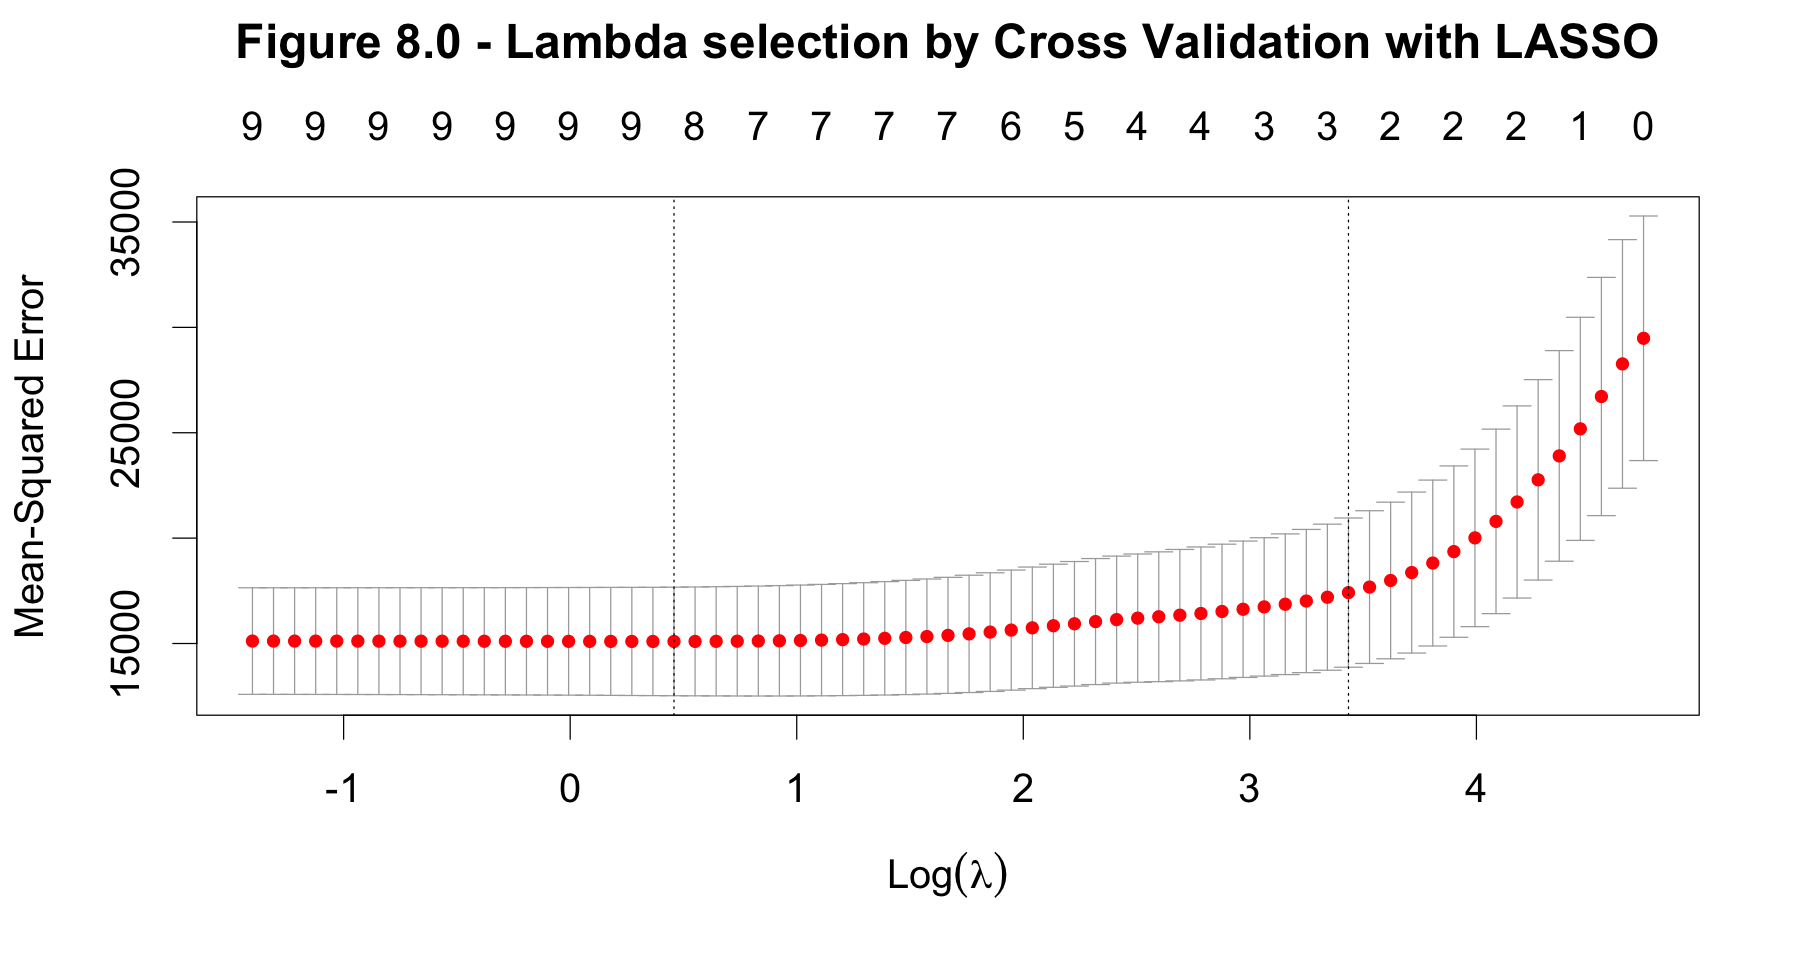

In [63]:
options(repr.plot.width = 15, repr.plot.height = 8)

# Plotting the range of lambda values vs. MSE
par(mfrow = c(1, 1), cex = 2)
phone_cv_lambda %>%
  plot(
    main = "Figure 8.0 - Lambda selection by Cross Validation with LASSO\n\n"
  )

In [64]:
# Storing the min value of lambda
phone_lambda_min <- round(phone_cv_lambda$lambda.min, 3)
round(log(phone_lambda_min), 2)

[1] 0.46

We use `glmnet()` to fit the Lasso model with optimal penalty parameter.

In [65]:
# Building LASSO model with the min lambda
phone_model_lasso <- glmnet(
  x = phone_training_matrix_x,
  y = phone_training_matrix_y,
  alpha = 1,
  lambda = phone_lambda_min
)

In [66]:
# Obtaining out-of-sample predictions for `price` from the testing set using the lasso model
phone_model_lasso_test <- predict(
  object = phone_model_lasso,
  newx = phone_testing_matrix_x
)

# Calculating the RMSE value for the lasso model
phone_model_lasso_rmse <- rmse(
  preds = phone_model_lasso_test,
  actuals = phone_testing$price
)
phone_model_lasso_rmse

[1] 114.2197

## 3. Discussion

### 3.1 Model Evaluation

We compare the RMSEs across various models we fit.

In [67]:
# Storing full model's RMSE in the results tibble
phone_rmses <- tibble(
  model = c(
      "OLS Full Regression",
      "OLS Stepwise Reduced Regression (6)",
      "OLS Stepwise Reduced Regression (7)",
      "OLS Stepwise Reduced Regression (8)",
      "LASSO Regression with min MSE",
      "OLS Full Regression with Correlation Reduced",
      "OLS Single Covariate"
  ),
  rmse = c(
      phone_model_full_rmse,
      phone_model_stepwise_6_rmse,
      phone_model_stepwise_7_rmse,
      phone_model_stepwise_8_rmse,
      phone_model_lasso_rmse,
      phone_model_full_correlation_reduced_rmse,
      phone_model_single_covariate_rmse
  )
)
phone_rmses

model,rmse
<chr>,<dbl>
OLS Full Regression,114.1929
OLS Stepwise Reduced Regression (6),114.0622
OLS Stepwise Reduced Regression (7),114.0210
OLS Stepwise Reduced Regression (8),114.0544
LASSO Regression with min MSE,114.2197
OLS Full Regression with Correlation Reduced,114.5909
OLS Single Covariate,132.5474


Table 13.0 - Comparing RMSEs across Models

As one can see, the OLS Stepwise Reduced Regression with 7 covariates performed the best in terms of RMSE. Still, our linear models explained 52.8% of the training set's variation. Therefore, there's undoubtedly a space for improvement in future studies.

### 3.2 Limitations of Methods

There were several limitations with our methods.
1. assuming linearity
2. variable type for `processor`, `ram`, `storage`, and `num_of_sims`
3. assuming normality of residuals

#### 3.2.1 Assuming Linearity

We did not check the linearity assumption yet still assumed that our variables are linearly related. However, the scatter plots of `price` vs. each input variable below show that most variables have a weak linear relationship with `price`.

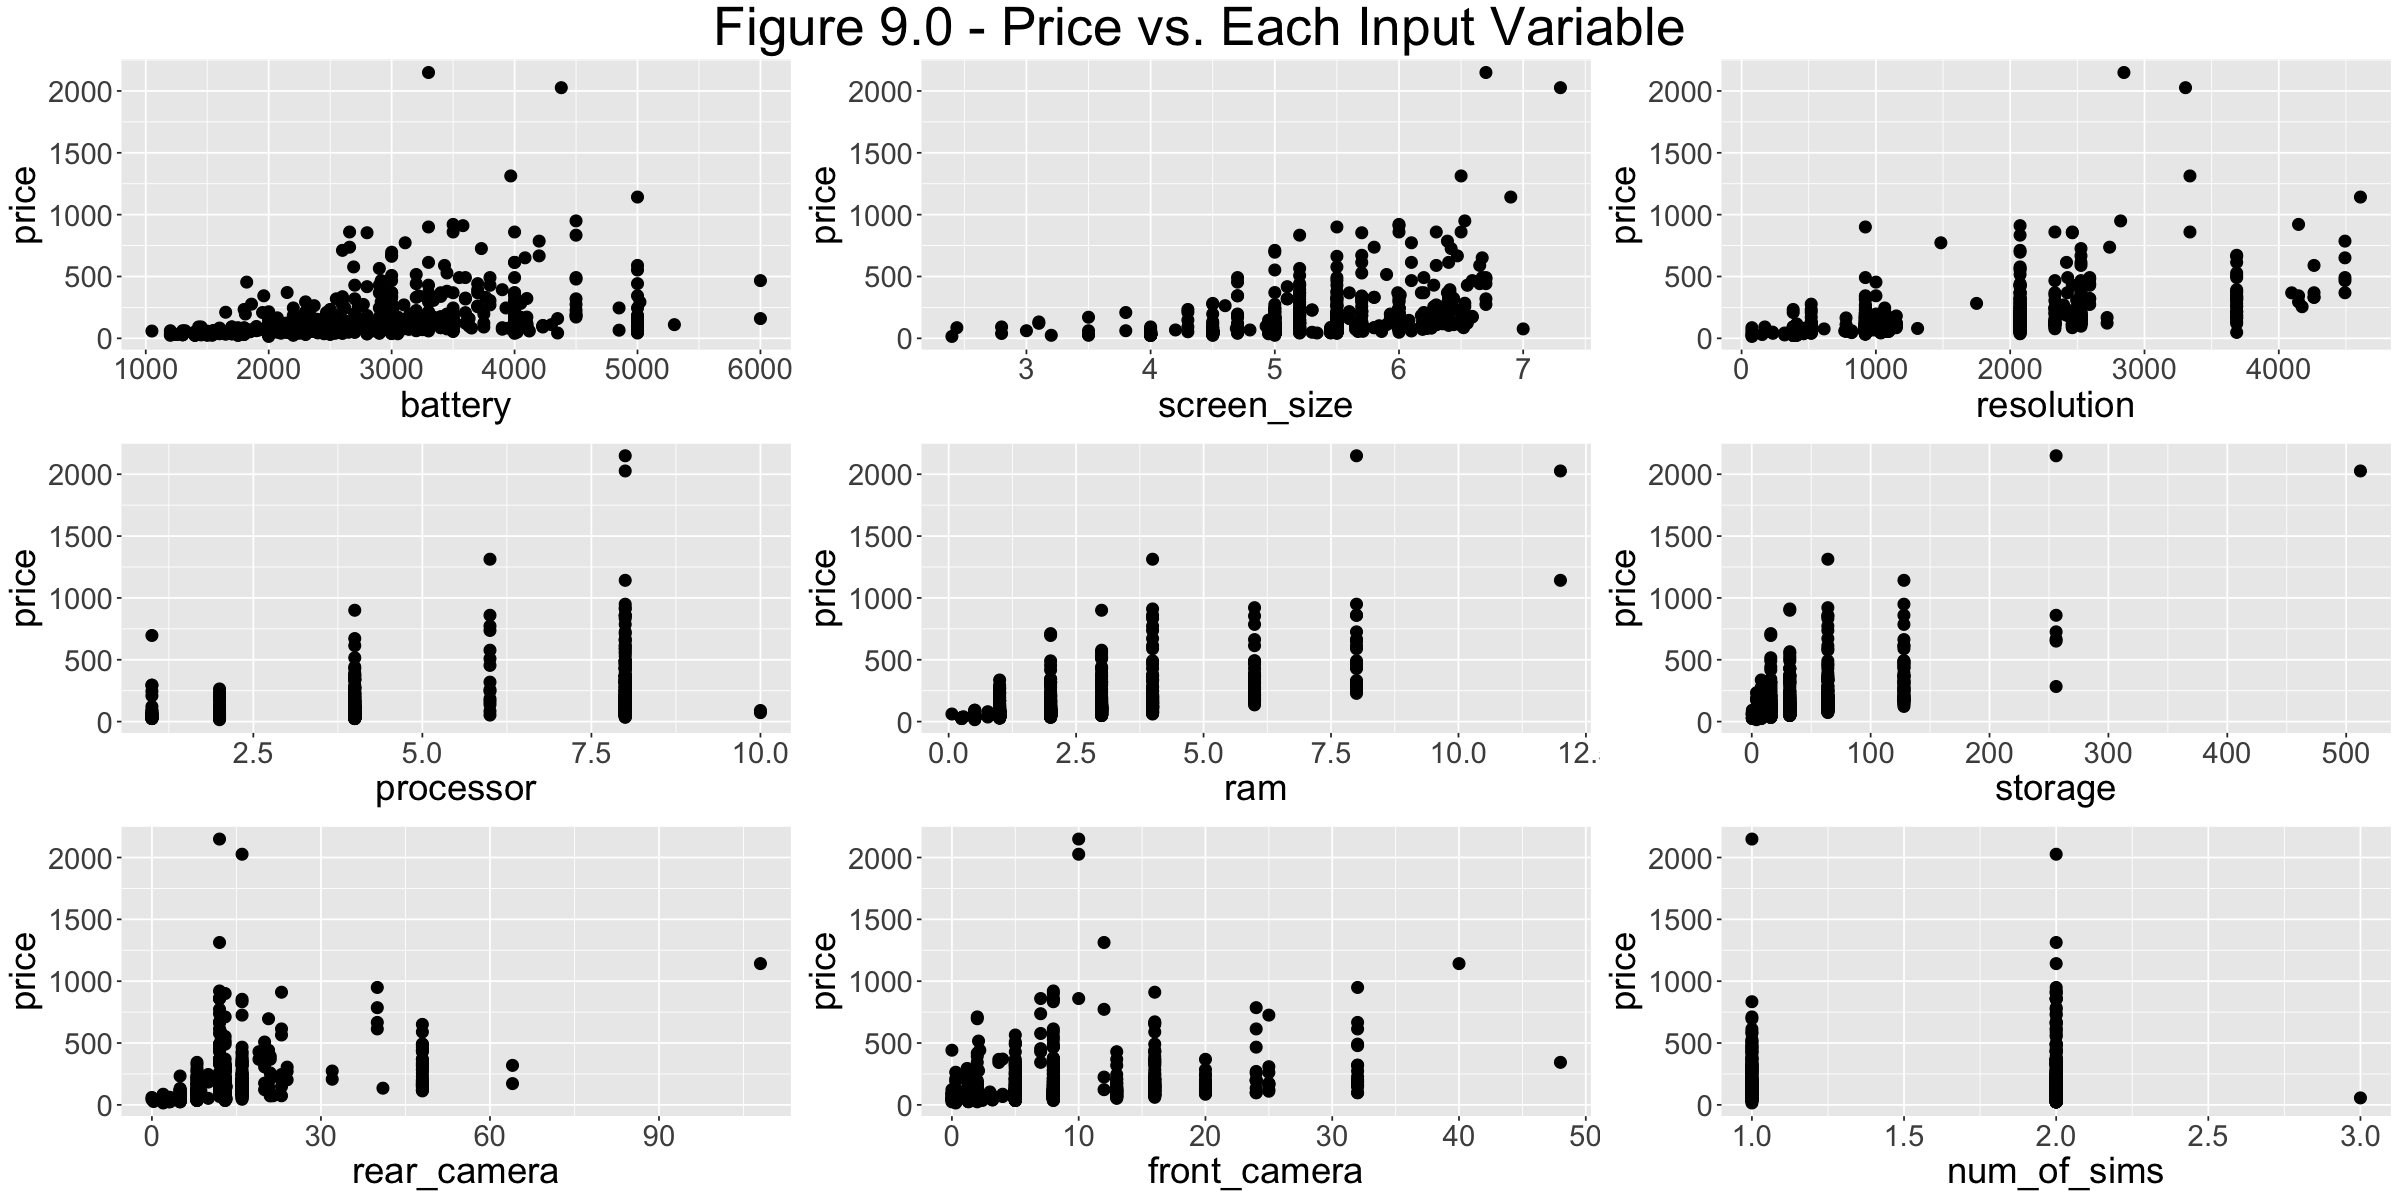

In [68]:
options(repr.plot.width = 20, repr.plot.height = 10)

# Creating scatter plots between all variables
plots <- select_if(phone_training, is.numeric) %>%
  ggpairs()

# Printing the scatter plots between price and an each input variable
grid.arrange(plots[2, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[3, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[4, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[5, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[6, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[7, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[8, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[9, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[10, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             nrow = 3, ncol = 3,
             top = textGrob("Figure 9.0 - Price vs. Each Input Variable",
                            gp = gpar(fontsize = font_size + 10))
)

Thus, our models violated the linearity assumption. Future studies may fix this issue by performing variable transformations, requiring reinterpreting the data.

#### 3.2.2 Variable Type for `processor`, `ram`, `storage`, and  `num_of_sims`

Despite being numeric values, values for variables such as `processor` or `ram` are often limited to select choices. For example, phones often come with 16gb or 32gb ram choices not 12.5. 

It might be better to treat `processor`, `ram`, `storage`, and `num_of_sims` as categorical variables rather than continuous. This change would involve adjusting the methodology of selecting significant variables: it would be necessary to use F-tests instead of the forward selection algorithm we applied. Therefore, future analyses can try this method and compare the results to ours.

#### 3.2.3 Assuming Normality of Residuals

We assumed the normality of the residuals for our fitted models. However, their distribution plots below indicate right skewness, which means our models don't explain all trends in the data. One potential remedy is building a model using interaction terms. This addition would cover the cases when, for example, an independent variable `A` influences the `price` differently depending on the values of another independent variable `B` (Interactions in Multiple Linear Regression Basic Ideas).

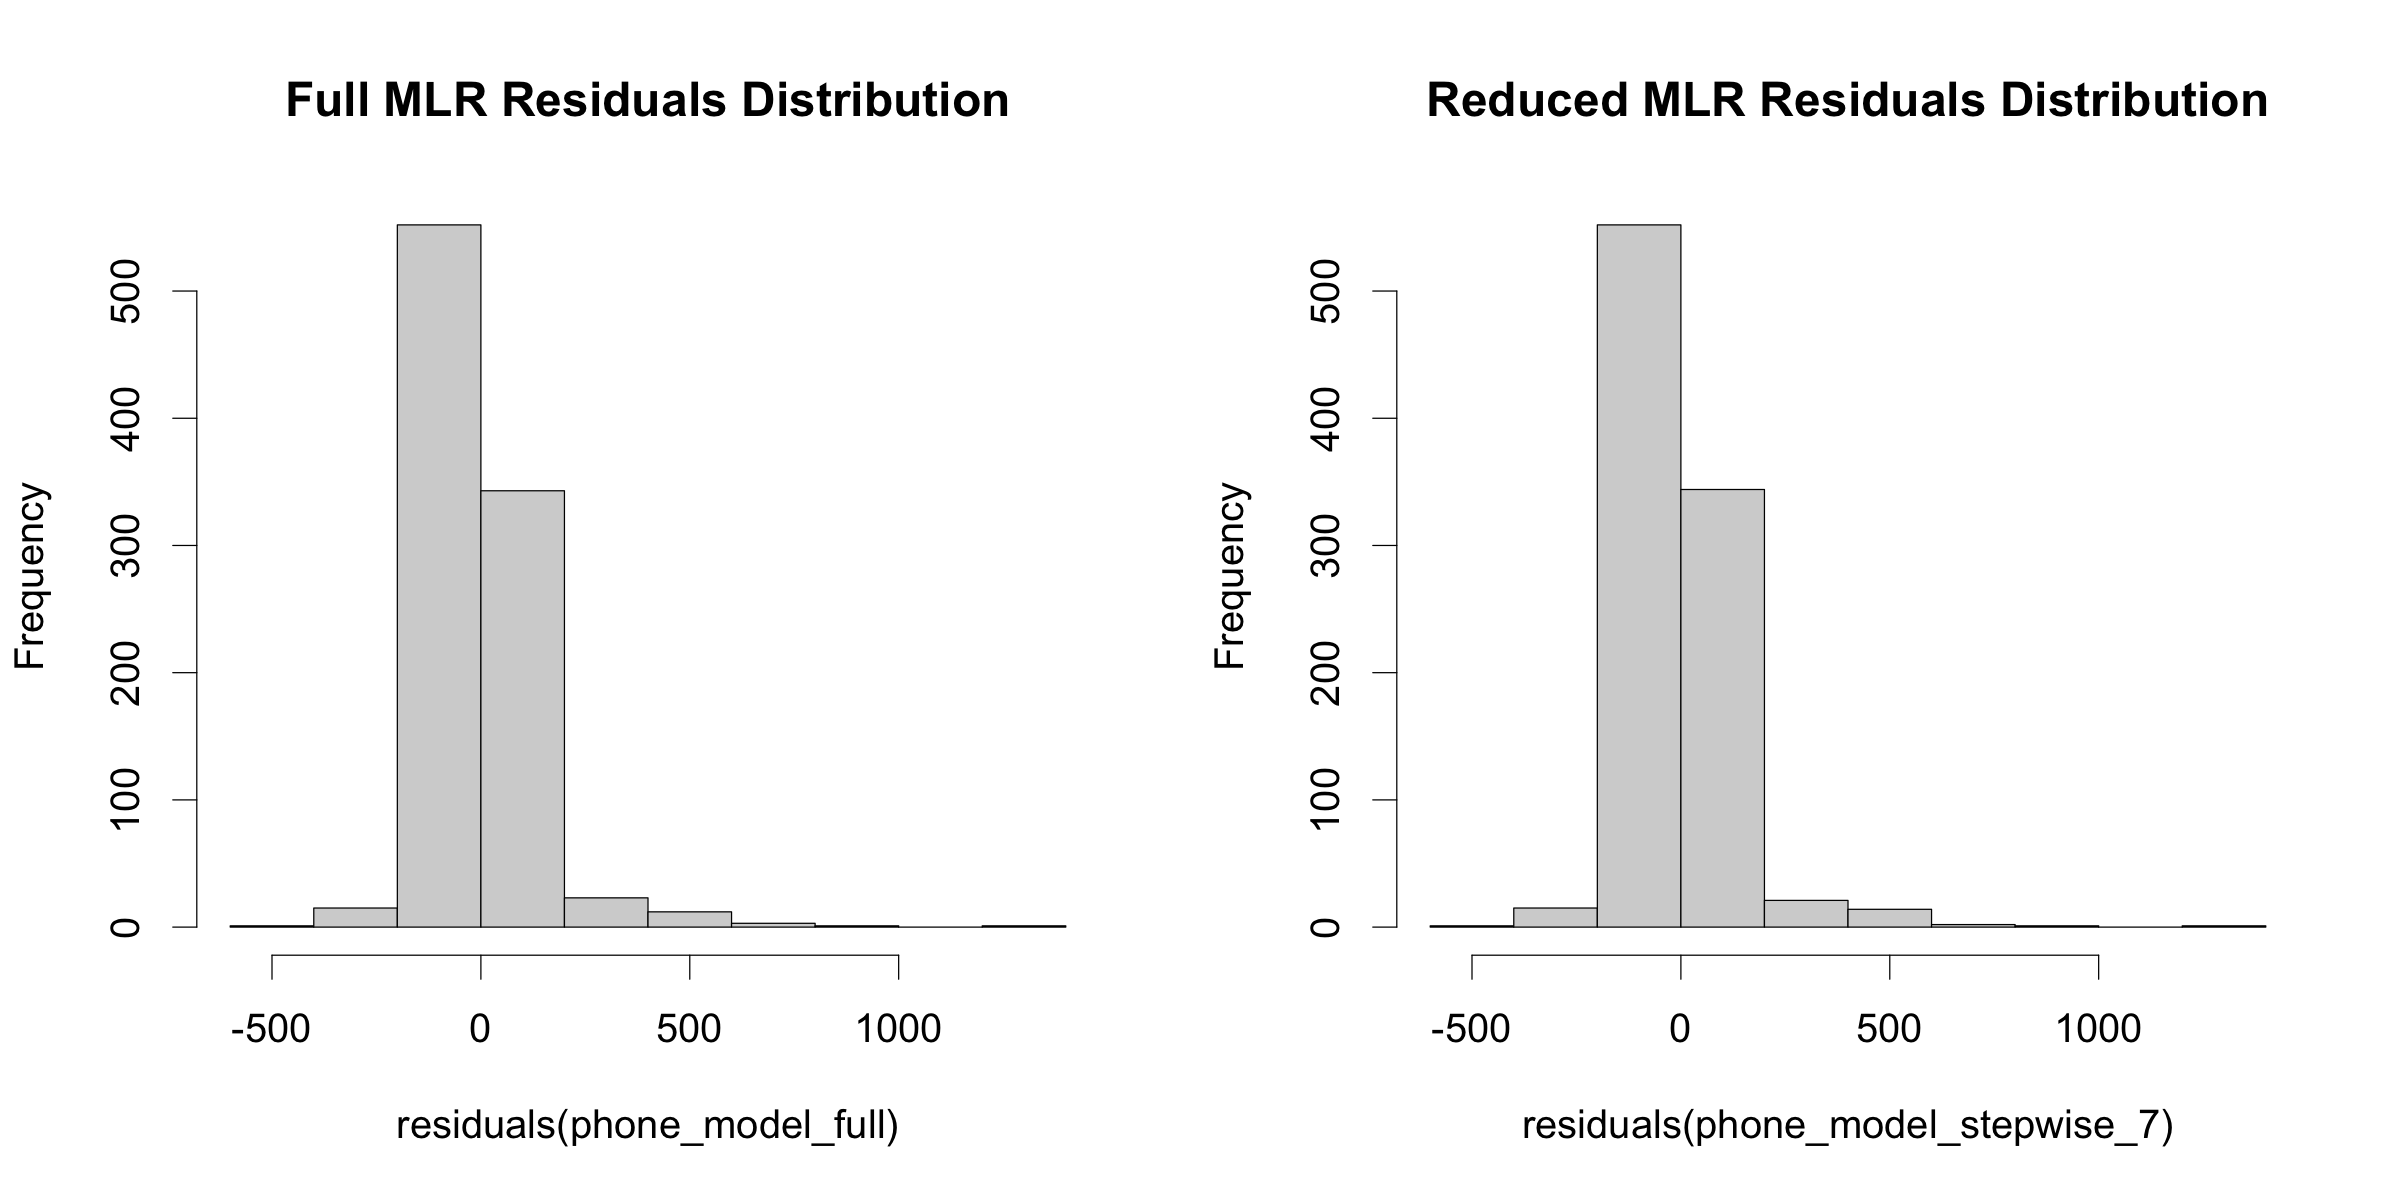

In [69]:
options(repr.plot.width = 20, repr.plot.height = 10)

# Plotting the distributions of residuals for full and reduced MLR models
# https://stackoverflow.com/a/10907452/18184038
par(mfrow = c(1, 2), cex = 2)
hist(residuals(phone_model_full),
     main = "Full MLR Residuals Distribution")
hist(residuals(phone_model_stepwise_7),
     main = "Reduced MLR Residuals Distribution")

Figure 10.0 - Observing Residuals Distribution between Full MLR and Reduced MLR Models

#### 3.2.4 High VIF

From our EDA, we can see that our data still had a max VIF value above 6, which is high according to some scholars (Bock). Therefore, future studies can use more advanced techniques for resolving multicollinearity, such as Principal component analysis (PCA).

### 3.3 Limitations of Dataset

Additionally, there are several limitations of the data set, which might have prevented our analysis from being successful.

Even though the data set was published in 2022, it missed variables describing critical features of modern smartphones. For example, the data did not have variables for screen refresh rate, availability of NFS module, or 5G compatibility, which may influence smartphone prices today. This lack of input variables can be corrected by re-parsing the website and retrieving these new features.

The data contained smartphone observations from the Indian market, so our study assumed that its prices reflected the global situation. However, it's not always the case. For example, iPhone prices in the US are significantly lower (Hilsenteger). Future studies can fix this limitation by parsing websites from different regions and randomly selecting phones from this international data set.

### 3.3 Conclusion

Through building models and calculating their Root Mean Square Error, we found that the OLS stepwise reduced regression model has the lowest RMSE. Therefore, we would choose it to predict a phone's market price given the device's characteristics, even though this linear regression model is not as effective in general. The model has the following coefficients and this equation:

In [70]:
phone_model_stepwise_7


Call:
lm(formula = price ~ battery + resolution + processor + ram + 
    storage + front_camera + num_of_sims, data = .)

Coefficients:
 (Intercept)       battery    resolution     processor           ram  
   112.26509      -0.01064       0.05222      -6.80954      24.87554  
     storage  front_camera   num_of_sims  
     2.18798      -5.00971     -34.59811  


`price = -0.011 * battery + 0.052 * resolution - 6.810 * processor + 24.876 * ram + 2.188 * storage - 5.010 * front_camera - 34.598 * num_of_sims + 112.265`

This finding could help people evaluate the price of a phone given its features, so consumers may avoid wasting money to some extent.
We expected that `ram` and `storage` would be significant for predicting a phone's price, and the model shows their significance. So, the result is what we expected. However, the `num_of_sims` is the most significant variable in our best regression model, which does not align with scholarly findings (Listianingrum et al.), so it's possible to improve the model as described in the evaluation above.

Regarding further research questions, this analysis could lead to future studies, such as price comparison between phones with identical performance but from different brands. 

Thus, in our analysis, the reduced MLR model performed best. Therefore, the variables selected by its shrinkage algorithm are significant for predicting a phone's price.

## 4. References

“Best Mobile Phones in India | Latest & New Smartphones Price.” *Gadgets 360*, 2020, www.gadgets360.com/mobiles/best-phones. Accessed 3 Dec. 2022.

Bock, Tim. “What Are Variance Inflation Factors (VIFs)? | Displayr.com.” *Displayr*, 6 Apr. 2018, www.displayr.com/variance-inflation-factors-vifs/.

Garai, Pratik. “Mobile Phone Specifications and Prices.” *Www.kaggle.com*, 14 Aug. 2022, www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices. Accessed 4 Dec. 2022.

Hayes, Adam. “Multiple Linear Regression (MLR) Definition, Formula, and Example.” *Investopedia*, 23 June 2022, www.investopedia.com/terms/m/mlr.asp#:~:text=The%20multiple%20regression%20model%20is. Accessed 6 Dec. 2022.

Hilsenteger, Lewis. “IPhone 14 ESIM Controversy Explained.” *Www.youtube.com*, 12 Sept. 2022, www.youtube.com/watch?t=543&v=DLILlKdELEk&feature=youtu.be. Accessed 3 Dec. 2022.

K. Srujan Raju, et al. *Data Engineering and Communication Technology*. Springer, 9 Jan. 2020, p. 773.

Kobie, Nicole. “Why Does Buying a New Phone Have to Be so - ProQuest.” *Www.proquest.com*, Apr. 2017, www.proquest.com/docview/1985885659?accountid=14656&forcedol=true&pq-origsite=summon. Accessed 3 Dec. 2022.

Kumar, Ajitesh. “Correlation Concepts, Matrix & Heatmap Using Seaborn.” *Data Analytics*, 16 Apr. 2022, vitalflux.com/correlation-heatmap-with-seaborn-pandas/#:~:text=with%20each%20other.-.

Listianingrum, T, et al. “Smartphone Hedonic Price Study Based on Online Retail Price in Indonesia.” *Journal of Physics: Conference Series*, vol. 1863, no. 1, 1 Mar. 2021, p. 012032, 10.1088/1742-6596/1863/1/012032. Accessed 1 May 2022.

Potters, Charles. “Variance Inflation Factor (VIF).” *Investopedia*, 26 July 2022, www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=Variance%20inflation%20factor%20measures%20how.

Tanveer, Muhammad, et al. “Mobile Phone Buying Decisions among Young Adults: An Empirical Study of Influencing Factors.” *Sustainability*, vol. 13, no. 19, 27 Sept. 2021, p. 10705, 10.3390/su131910705. Accessed 8 Oct. 2021.

Wu, Songhao. “Multi-Collinearity in Regression.” *Medium*, 23 May 2020, towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea.

Word count: **1921**